<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# LSTUR: Neural News Recommendation with Long- and Short-term User Representations
LSTUR \[1\] is a news recommendation approach capturing users' both long-term preferences and short-term interests. The core of LSTUR is a news encoder and a user encoder.  In the news encoder, we learn representations of news from their titles. In user encoder, we propose to learn long-term
user representations from the embeddings of their IDs. In addition, we propose to learn short-term user representations from their recently browsed news via GRU network. Besides, we propose two methods to combine
long-term and short-term user representations. The first one is using the long-term user representation to initialize the hidden state of the GRU network in short-term user representation. The second one is concatenating both
long- and short-term user representations as a unified user vector.

## Properties of LSTUR:
- LSTUR captures users' both long-term and short term preference.
- It uses embeddings of users' IDs to learn long-term user representations.
- It uses users' recently browsed news via GRU network to learn short-term user representations.

## Data format:
For quicker training and evaluaiton, we sample MINDdemo dataset of 5k users from [MIND small dataset](https://msnews.github.io/). The MINDdemo dataset has the same file format as MINDsmall and MINDlarge. If you want to try experiments on MINDsmall and MINDlarge, please change the dowload source. Select the MIND_type parameter from ['large', 'small', 'demo'] to choose dataset.
 
**MINDdemo_train** is used for training, and **MINDdemo_dev** is used for evaluation. Training data and evaluation data are composed of a news file and a behaviors file. You can find more detailed data description in [MIND repo](https://github.com/msnews/msnews.github.io/blob/master/assets/doc/introduction.md)

### news data
This file contains news information including newsid, category, subcatgory, news title, news abstarct, news url and entities in news title, entities in news abstarct.
One simple example: <br>

`N46466	lifestyle	lifestyleroyals	The Brands Queen Elizabeth, Prince Charles, and Prince Philip Swear By	Shop the notebooks, jackets, and more that the royals can't live without.	https://www.msn.com/en-us/lifestyle/lifestyleroyals/the-brands-queen-elizabeth,-prince-charles,-and-prince-philip-swear-by/ss-AAGH0ET?ocid=chopendata	[{"Label": "Prince Philip, Duke of Edinburgh", "Type": "P", "WikidataId": "Q80976", "Confidence": 1.0, "OccurrenceOffsets": [48], "SurfaceForms": ["Prince Philip"]}, {"Label": "Charles, Prince of Wales", "Type": "P", "WikidataId": "Q43274", "Confidence": 1.0, "OccurrenceOffsets": [28], "SurfaceForms": ["Prince Charles"]}, {"Label": "Elizabeth II", "Type": "P", "WikidataId": "Q9682", "Confidence": 0.97, "OccurrenceOffsets": [11], "SurfaceForms": ["Queen Elizabeth"]}]	[]`
<br>

In general, each line in data file represents information of one piece of news: <br>

`[News ID] [Category] [Subcategory] [News Title] [News Abstrct] [News Url] [Entities in News Title] [Entities in News Abstract] ...`

<br>

We generate a word_dict file to tranform words in news title to word indexes, and a embedding matrix is initted from pretrained glove embeddings.

### behaviors data
One simple example: <br>
`1	U82271	11/11/2019 3:28:58 PM	N3130 N11621 N12917 N4574 N12140 N9748	N13390-0 N7180-0 N20785-0 N6937-0 N15776-0 N25810-0 N20820-0 N6885-0 N27294-0 N18835-0 N16945-0 N7410-0 N23967-0 N22679-0 N20532-0 N26651-0 N22078-0 N4098-0 N16473-0 N13841-0 N15660-0 N25787-0 N2315-0 N1615-0 N9087-0 N23880-0 N3600-0 N24479-0 N22882-0 N26308-0 N13594-0 N2220-0 N28356-0 N17083-0 N21415-0 N18671-0 N9440-0 N17759-0 N10861-0 N21830-0 N8064-0 N5675-0 N15037-0 N26154-0 N15368-1 N481-0 N3256-0 N20663-0 N23940-0 N7654-0 N10729-0 N7090-0 N23596-0 N15901-0 N16348-0 N13645-0 N8124-0 N20094-0 N27774-0 N23011-0 N14832-0 N15971-0 N27729-0 N2167-0 N11186-0 N18390-0 N21328-0 N10992-0 N20122-0 N1958-0 N2004-0 N26156-0 N17632-0 N26146-0 N17322-0 N18403-0 N17397-0 N18215-0 N14475-0 N9781-0 N17958-0 N3370-0 N1127-0 N15525-0 N12657-0 N10537-0 N18224-0`
<br>

In general, each line in data file represents one instance of an impression. The format is like: <br>

`[Impression ID] [User ID] [Impression Time] [User Click History] [Impression News]`

<br>

User Click History is the user historical clicked news before Impression Time. Impression News is the displayed news in an impression, which format is:<br>

`[News ID 1]-[label1] ... [News ID n]-[labeln]`

<br>
Label represents whether the news is clicked by the user. All information of news in User Click History and Impression News can be found in news data file.

# Global settings and imports

The following command is only required in Google Collab. The goal is to set Tensorflow version to 1.x instead of the default 2.x. If this code is executed on a different notebook platform, please assign the notebook a kernel that contains Tensorflow 1.x and not 2.x.

In [ ]:
# !pip install matplotlib==3.4.0

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Required only in Google Collab, to change the default TensorFlow version to 1.x instead of the default 2.x.
# %tensorflow_version 1.x

In [ ]:
import tensorflow as tf
tf.version.VERSION

'1.15.5'

In [ ]:
!pip install scrapbook
!pip install backoff

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [ ]:
# !pip install git+https://github.com/microsoft/recommenders/#egg=reco_utils

In [ ]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import os
import logging
import requests
import math
import zipfile
from contextlib import contextmanager
from tempfile import TemporaryDirectory
from tqdm import tqdm
import backoff


log = logging.getLogger(__name__)


@backoff.on_exception(
    backoff.expo,
    (requests.exceptions.HTTPError, requests.exceptions.ChunkedEncodingError),
    max_tries=5,
)
def maybe_download(url, filename=None, work_directory=".", expected_bytes=None):
    """Download a file if it is not already downloaded.
    Args:
        filename (str): File name.
        work_directory (str): Working directory.
        url (str): URL of the file to download.
        expected_bytes (int): Expected file size in bytes.
    Returns:
        str: File path of the file downloaded.
    """
    if filename is None:
        filename = url.split("/")[-1]
    os.makedirs(work_directory, exist_ok=True)
    filepath = os.path.join(work_directory, filename)
    if not os.path.exists(filepath):

        r = requests.get(url, stream=True)
        total_size = int(r.headers.get("content-length", 0))
        block_size = 1024
        num_iterables = math.ceil(total_size / block_size)

        with open(filepath, "wb") as file:
            for data in tqdm(
                r.iter_content(block_size),
                total=num_iterables,
                unit="KB",
                unit_scale=True,
            ):
                file.write(data)
    else:
        log.info("File {} already downloaded".format(filepath))
    if expected_bytes is not None:
        statinfo = os.stat(filepath)
        if statinfo.st_size != expected_bytes:
            os.remove(filepath)
            raise IOError("Failed to verify {}".format(filepath))

    return filepath


@contextmanager
def download_path(path=None):
    """Return a path to download data. If `path=None`, then it yields a temporal path that is eventually deleted,
    otherwise the real path of the input.
    Args:
        path (str): Path to download data.
    Returns:
        str: Real path where the data is stored.
    Examples:
        >>> with download_path() as path:
        >>> ... maybe_download(url="http://example.com/file.zip", work_directory=path)
    """
    if path is None:
        tmp_dir = TemporaryDirectory()
        try:
            yield tmp_dir.name
        finally:
            tmp_dir.cleanup()
    else:
        path = os.path.realpath(path)
        yield path


def unzip_file(zip_src, dst_dir, clean_zip_file=True):
    """Unzip a file
    Args:
        zip_src (str): Zip file.
        dst_dir (str): Destination folder.
        clean_zip_file (bool): Whether or not to clean the zip file.
    """
    fz = zipfile.ZipFile(zip_src, "r")
    for file in fz.namelist():
        fz.extract(file, dst_dir)
    if clean_zip_file:
        os.remove(zip_src)

In [ ]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.


import os
from sklearn.metrics import (
    roc_auc_score,
    log_loss,
    mean_squared_error,
    accuracy_score,
    f1_score,
)
import numpy as np
import yaml
import zipfile
import json
import pickle as pkl
import tensorflow as tf

def flat_config(config):
    """Flat config loaded from a yaml file to a flat dict.
    
    Args:
        config (dict): Configuration loaded from a yaml file.
    Returns:
        dict: Configuration dictionary.
    """
    f_config = {}
    category = config.keys()
    for cate in category:
        for key, val in config[cate].items():
            f_config[key] = val
    return f_config


def check_type(config):
    """Check that the config parameters are the correct type
    
    Args:
        config (dict): Configuration dictionary.
    Raises:
        TypeError: If the parameters are not the correct type.
    """

    int_parameters = [
        "word_size",
        "entity_size",
        "doc_size",
        "history_size",
        "FEATURE_COUNT",
        "FIELD_COUNT",
        "dim",
        "epochs",
        "batch_size",
        "show_step",
        "save_epoch",
        "PAIR_NUM",
        "DNN_FIELD_NUM",
        "attention_layer_sizes",
        "n_user",
        "n_item",
        "n_user_attr",
        "n_item_attr",
        "item_embedding_dim",
        "cate_embedding_dim",
        "user_embedding_dim",
        "max_seq_length",
        "hidden_size",
        "T",
        "L",
        "n_v",
        "n_h",
        "kernel_size",
        "min_seq_length",
        "attention_size",
        "epochs",
        "batch_size",
        "show_step",
        "save_epoch",
        "train_num_ngs",
    ]
    for param in int_parameters:
        if param in config and not isinstance(config[param], int):
            raise TypeError("Parameters {0} must be int".format(param))

    float_parameters = [
        "init_value",
        "learning_rate",
        "embed_l2",
        "embed_l1",
        "layer_l2",
        "layer_l1",
        "mu",
    ]
    for param in float_parameters:
        if param in config and not isinstance(config[param], float):
            raise TypeError("Parameters {0} must be float".format(param))

    str_parameters = [
        "train_file",
        "eval_file",
        "test_file",
        "infer_file",
        "method",
        "load_model_name",
        "infer_model_name",
        "loss",
        "optimizer",
        "init_method",
        "attention_activation",
        "user_vocab",
        "item_vocab",
        "cate_vocab",
    ]
    for param in str_parameters:
        if param in config and not isinstance(config[param], str):
            raise TypeError("Parameters {0} must be str".format(param))

    list_parameters = [
        "layer_sizes",
        "activation",
        "dropout",
        "att_fcn_layer_sizes",
        "dilations",
    ]
    for param in list_parameters:
        if param in config and not isinstance(config[param], list):
            raise TypeError("Parameters {0} must be list".format(param))


def check_nn_config(f_config):
    """Check neural networks configuration.
    
    Args:
        f_config (dict): Neural network configuration.
    
    Raises:
        ValueError: If the parameters are not correct.
    """
    if f_config["model_type"] in ["fm", "FM"]:
        required_parameters = ["FEATURE_COUNT", "dim", "loss", "data_format", "method"]
    elif f_config["model_type"] in ["lr", "LR"]:
        required_parameters = ["FEATURE_COUNT", "loss", "data_format", "method"]
    elif f_config["model_type"] in ["dkn", "DKN"]:
        required_parameters = [
            "doc_size",
            "history_size",
            "wordEmb_file",
            "entityEmb_file",
            "contextEmb_file",
            "news_feature_file",
            "user_history_file",
            "word_size",
            "entity_size",
            "use_entity",
            "use_context",
            "data_format",
            "dim",
            "layer_sizes",
            "activation",
            "attention_activation",
            "attention_activation",
            "attention_dropout",
            "loss",
            "data_format",
            "dropout",
            "method",
            "num_filters",
            "filter_sizes",
        ]
    elif f_config["model_type"] in ["exDeepFM", "xDeepFM"]:
        required_parameters = [
            "FIELD_COUNT",
            "FEATURE_COUNT",
            "method",
            "dim",
            "layer_sizes",
            "cross_layer_sizes",
            "activation",
            "loss",
            "data_format",
            "dropout",
        ]
    if f_config["model_type"] in ["gru4rec", "GRU4REC", "GRU4Rec"]:
        required_parameters = [
            "item_embedding_dim",
            "cate_embedding_dim",
            "max_seq_length",
            "loss",
            "method",
            "user_vocab",
            "item_vocab",
            "cate_vocab",
            "hidden_size",
        ]
    elif f_config["model_type"] in ["caser", "CASER", "Caser"]:
        required_parameters = [
            "item_embedding_dim",
            "cate_embedding_dim",
            "user_embedding_dim",
            "max_seq_length",
            "loss",
            "method",
            "user_vocab",
            "item_vocab",
            "cate_vocab",
            "T",
            "L",
            "n_v",
            "n_h",
            "min_seq_length",
        ]
    elif f_config["model_type"] in ["asvd", "ASVD", "a2svd", "A2SVD"]:
        required_parameters = [
            "item_embedding_dim",
            "cate_embedding_dim",
            "max_seq_length",
            "loss",
            "method",
            "user_vocab",
            "item_vocab",
            "cate_vocab",
        ]
    elif f_config["model_type"] in ["slirec", "sli_rec", "SLI_REC", "Sli_rec"]:
        required_parameters = [
            "item_embedding_dim",
            "cate_embedding_dim",
            "max_seq_length",
            "loss",
            "method",
            "user_vocab",
            "item_vocab",
            "cate_vocab",
            "attention_size",
            "hidden_size",
            "att_fcn_layer_sizes",
        ]
    elif f_config["model_type"] in [
        "nextitnet",
        "next_it_net",
        "NextItNet",
        "NEXT_IT_NET",
    ]:
        required_parameters = [
            "item_embedding_dim",
            "cate_embedding_dim",
            "user_embedding_dim",
            "max_seq_length",
            "loss",
            "method",
            "user_vocab",
            "item_vocab",
            "cate_vocab",
            "dilations",
            "kernel_size",
            "min_seq_length",
        ]
    else:
        required_parameters = []

    # check required parameters
    for param in required_parameters:
        if param not in f_config:
            raise ValueError("Parameters {0} must be set".format(param))

    if f_config["model_type"] in ["exDeepFM", "xDeepFM"]:
        if f_config["data_format"] != "ffm":
            raise ValueError(
                "For xDeepFM model, data format must be 'ffm', but your set is {0}".format(
                    f_config["data_format"]
                )
            )
    elif f_config["model_type"] in ["dkn", "DKN"]:
        if f_config["data_format"] != "dkn":
            raise ValueError(
                "For dkn model, data format must be 'dkn', but your set is {0}".format(
                    f_config["data_format"]
                )
            )
    check_type(f_config)


def load_yaml(filename):
    """Load a yaml file.
    Args:
        filename (str): Filename.
    Returns:
        dict: Dictionary.
    """
    try:
        with open(filename, "r") as f:
            config = yaml.load(f, yaml.SafeLoader)
        return config
    except FileNotFoundError:  # for file not found
        raise
    except Exception as e:  # for other exceptions
        raise IOError("load {0} error!".format(filename))


def create_hparams(flags):
    """Create the model hyperparameters.
    Args:
        flags (dict): Dictionary with the model requirements.
    Returns:
        obj: Hyperparameter object in TF (tf.contrib.training.HParams).
    """
    return tf.contrib.training.HParams(
        # data
        kg_file=flags["kg_file"] if "kg_file" in flags else None,
        user_clicks=flags["user_clicks"] if "user_clicks" in flags else None,
        FEATURE_COUNT=flags["FEATURE_COUNT"] if "FEATURE_COUNT" in flags else None,
        FIELD_COUNT=flags["FIELD_COUNT"] if "FIELD_COUNT" in flags else None,
        data_format=flags["data_format"] if "data_format" in flags else None,
        PAIR_NUM=flags["PAIR_NUM"] if "PAIR_NUM" in flags else None,
        DNN_FIELD_NUM=flags["DNN_FIELD_NUM"] if "DNN_FIELD_NUM" in flags else None,
        n_user=flags["n_user"] if "n_user" in flags else None,
        n_item=flags["n_item"] if "n_item" in flags else None,
        n_user_attr=flags["n_user_attr"] if "n_user_attr" in flags else None,
        n_item_attr=flags["n_item_attr"] if "n_item_attr" in flags else None,
        iterator_type=flags["iterator_type"] if "iterator_type" in flags else None,
        SUMMARIES_DIR=flags["SUMMARIES_DIR"] if "SUMMARIES_DIR" in flags else None,
        MODEL_DIR=flags["MODEL_DIR"] if "MODEL_DIR" in flags else None,
        # dkn
        wordEmb_file=flags["wordEmb_file"] if "wordEmb_file" in flags else None,
        entityEmb_file=flags["entityEmb_file"] if "entityEmb_file" in flags else None,
        contextEmb_file=flags["contextEmb_file"]
        if "contextEmb_file" in flags
        else None,
        news_feature_file=flags["news_feature_file"]
        if "news_feature_file" in flags
        else None,
        user_history_file=flags["user_history_file"]
        if "user_history_file" in flags
        else None,
        use_entity=flags["use_entity"] if "use_entity" in flags else True,
        use_context=flags["use_context"] if "use_context" in flags else True,
        doc_size=flags["doc_size"] if "doc_size" in flags else None,
        history_size=flags["history_size"] if "history_size" in flags else None,
        word_size=flags["word_size"] if "word_size" in flags else None,
        entity_size=flags["entity_size"] if "entity_size" in flags else None,
        entity_dim=flags["entity_dim"] if "entity_dim" in flags else None,
        entity_embedding_method=flags["entity_embedding_method"]
        if "entity_embedding_method" in flags
        else None,
        transform=flags["transform"] if "transform" in flags else None,
        train_ratio=flags["train_ratio"] if "train_ratio" in flags else None,
        # model
        dim=flags["dim"] if "dim" in flags else None,
        layer_sizes=flags["layer_sizes"] if "layer_sizes" in flags else None,
        cross_layer_sizes=flags["cross_layer_sizes"]
        if "cross_layer_sizes" in flags
        else None,
        cross_layers=flags["cross_layers"] if "cross_layers" in flags else None,
        activation=flags["activation"] if "activation" in flags else None,
        cross_activation=flags["cross_activation"]
        if "cross_activation" in flags
        else "identity",
        user_dropout=flags["user_dropout"] if "user_dropout" in flags else False,
        dropout=flags["dropout"] if "dropout" in flags else [0.0],
        attention_layer_sizes=flags["attention_layer_sizes"]
        if "attention_layer_sizes" in flags
        else None,
        attention_activation=flags["attention_activation"]
        if "attention_activation" in flags
        else None,
        attention_dropout=flags["attention_dropout"]
        if "attention_dropout" in flags
        else 0.0,
        model_type=flags["model_type"] if "model_type" in flags else None,
        method=flags["method"] if "method" in flags else None,
        load_saved_model=flags["load_saved_model"]
        if "load_saved_model" in flags
        else False,
        load_model_name=flags["load_model_name"]
        if "load_model_name" in flags
        else None,
        filter_sizes=flags["filter_sizes"] if "filter_sizes" in flags else None,
        num_filters=flags["num_filters"] if "num_filters" in flags else None,
        mu=flags["mu"] if "mu" in flags else None,
        fast_CIN_d=flags["fast_CIN_d"] if "fast_CIN_d" in flags else 0,
        use_Linear_part=flags["use_Linear_part"]
        if "use_Linear_part" in flags
        else False,
        use_FM_part=flags["use_FM_part"] if "use_FM_part" in flags else False,
        use_CIN_part=flags["use_CIN_part"] if "use_CIN_part" in flags else False,
        use_DNN_part=flags["use_DNN_part"] if "use_DNN_part" in flags else False,
        # train
        init_method=flags["init_method"] if "init_method" in flags else "tnormal",
        init_value=flags["init_value"] if "init_value" in flags else 0.01,
        embed_l2=flags["embed_l2"] if "embed_l2" in flags else 0.0000,
        embed_l1=flags["embed_l1"] if "embed_l1" in flags else 0.0000,
        layer_l2=flags["layer_l2"] if "layer_l2" in flags else 0.0000,
        layer_l1=flags["layer_l1"] if "layer_l1" in flags else 0.0000,
        cross_l2=flags["cross_l2"] if "cross_l2" in flags else 0.0000,
        cross_l1=flags["cross_l1"] if "cross_l1" in flags else 0.0000,
        reg_kg=flags["reg_kg"] if "reg_kg" in flags else 0.0000,
        learning_rate=flags["learning_rate"] if "learning_rate" in flags else 0.001,
        lr_rs=flags["lr_rs"] if "lr_rs" in flags else 1,
        lr_kg=flags["lr_kg"] if "lr_kg" in flags else 0.5,
        kg_training_interval=flags["kg_training_interval"]
        if "kg_training_interval" in flags
        else 5,
        max_grad_norm=flags["max_grad_norm"] if "max_grad_norm" in flags else 2,
        is_clip_norm=flags["is_clip_norm"] if "is_clip_norm" in flags else 0,
        dtype=flags["dtype"] if "dtype" in flags else 32,
        loss=flags["loss"] if "loss" in flags else None,
        optimizer=flags["optimizer"] if "optimizer" in flags else "adam",
        epochs=flags["epochs"] if "epochs" in flags else 10,
        batch_size=flags["batch_size"] if "batch_size" in flags else 1,
        enable_BN=flags["enable_BN"] if "enable_BN" in flags else False,
        # show info
        show_step=flags["show_step"] if "show_step" in flags else 1,
        save_model=flags["save_model"] if "save_model" in flags else True,
        save_epoch=flags["save_epoch"] if "save_epoch" in flags else 5,
        metrics=flags["metrics"] if "metrics" in flags else None,
        write_tfevents=flags["write_tfevents"] if "write_tfevents" in flags else False,
        # sequential
        item_embedding_dim=flags["item_embedding_dim"]
        if "item_embedding_dim" in flags
        else None,
        cate_embedding_dim=flags["cate_embedding_dim"]
        if "cate_embedding_dim" in flags
        else None,
        user_embedding_dim=flags["user_embedding_dim"]
        if "user_embedding_dim" in flags
        else None,
        train_num_ngs=flags["train_num_ngs"] if "train_num_ngs" in flags else 4,
        need_sample=flags["need_sample"] if "need_sample" in flags else True,
        embedding_dropout=flags["embedding_dropout"]
        if "embedding_dropout" in flags
        else 0.0,
        user_vocab=flags["user_vocab"] if "user_vocab" in flags else None,
        item_vocab=flags["item_vocab"] if "item_vocab" in flags else None,
        cate_vocab=flags["cate_vocab"] if "cate_vocab" in flags else None,
        pairwise_metrics=flags["pairwise_metrics"]
        if "pairwise_metrics" in flags
        else None,
        EARLY_STOP=flags["EARLY_STOP"] if "EARLY_STOP" in flags else 100,
        # gru4rec
        max_seq_length=flags["max_seq_length"] if "max_seq_length" in flags else None,
        hidden_size=flags["hidden_size"] if "hidden_size" in flags else None,
        # caser,
        L=flags["L"] if "L" in flags else None,
        T=flags["T"] if "T" in flags else None,
        n_v=flags["n_v"] if "n_v" in flags else None,
        n_h=flags["n_h"] if "n_h" in flags else None,
        min_seq_length=flags["min_seq_length"] if "min_seq_length" in flags else 1,
        # sli_rec
        attention_size=flags["attention_size"] if "attention_size" in flags else None,
        att_fcn_layer_sizes=flags["att_fcn_layer_sizes"]
        if "att_fcn_layer_sizes" in flags
        else None,
        # nextitnet
        dilations=flags["dilations"] if "dilations" in flags else None,
        kernel_size=flags["kernel_size"] if "kernel_size" in flags else None,
        # lightgcn
        embed_size=flags["embed_size"] if "embed_size" in flags else None,
        n_layers=flags["n_layers"] if "n_layers" in flags else None,
        decay=flags["decay"] if "decay" in flags else None,
        eval_epoch=flags["eval_epoch"] if "eval_epoch" in flags else None,
        top_k=flags["top_k"] if "top_k" in flags else None,
        # sum
        slots=flags["slots"] if "slots" in flags else 5,
        cell=flags["cell"] if "cell" in flags else "SUM",
    )


def prepare_hparams(yaml_file=None, **kwargs):
    """Prepare the model hyperparameters and check that all have the correct value.
    Args:
        yaml_file (str): YAML file as configuration.
    Returns:
        obj: Hyperparameter object in TF (tf.contrib.training.HParams).
    """
    if yaml_file is not None:
        config = load_yaml(yaml_file)
        config = flat_config(config)
    else:
        config = {}

    if kwargs:
        for name, value in kwargs.items():
            config[name] = value

    check_nn_config(config)
    return create_hparams(config)


def download_deeprec_resources(azure_container_url, data_path, remote_resource_name):
    """Download resources.
    Args:
        azure_container_url (str): URL of Azure container.
        data_path (str): Path to download the resources.
        remote_resource_name (str): Name of the resource.
    """
    os.makedirs(data_path, exist_ok=True)
    remote_path = azure_container_url + remote_resource_name
    maybe_download(remote_path, remote_resource_name, data_path)
    zip_ref = zipfile.ZipFile(os.path.join(data_path, remote_resource_name), "r")
    zip_ref.extractall(data_path)
    zip_ref.close()
    os.remove(os.path.join(data_path, remote_resource_name))


def mrr_score(y_true, y_score):
    """Computing mrr score metric.
    Args:
        y_true (np.ndarray): ground-truth labels.
        y_score (np.ndarray): predicted labels.
    
    Returns:
        np.ndarray: mrr scores.
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order)
    rr_score = y_true / (np.arange(len(y_true)) + 1)
    return np.sum(rr_score) / np.sum(y_true)


def ndcg_score(y_true, y_score, k=10):
    """Computing ndcg score metric at k.
    Args:
        y_true (np.ndarray): ground-truth labels.
        y_score (np.ndarray): predicted labels.
    Returns:
        np.ndarray: ndcg scores.
    """
    best = dcg_score(y_true, y_true, k)
    actual = dcg_score(y_true, y_score, k)
    return actual / best


def hit_score(y_true, y_score, k=10):
    """Computing hit score metric at k.
    Args:
        y_true (np.ndarray): ground-truth labels.
        y_score (np.ndarray): predicted labels.
    Returns:
        np.ndarray: hit score.
    """
    ground_truth = np.where(y_true == 1)[0]
    argsort = np.argsort(y_score)[::-1][:k]
    for idx in argsort:
        if idx in ground_truth:
            return 1
    return 0


def dcg_score(y_true, y_score, k=10):
    """Computing dcg score metric at k.
    Args:
        y_true (np.ndarray): ground-truth labels.
        y_score (np.ndarray): predicted labels.
    Returns:
        np.ndarray: dcg scores.
    """
    k = min(np.shape(y_true)[-1], k)
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)


def cal_metric(labels, preds, metrics):
    """Calculate metrics,such as auc, logloss.
    
    FIXME: 
        refactor this with the reco metrics and make it explicit.
    """
    res = {}
    for metric in metrics:
        if metric == "auc":
            auc = roc_auc_score(np.asarray(labels), np.asarray(preds))
            res["auc"] = round(auc, 4)
        elif metric == "rmse":
            rmse = mean_squared_error(np.asarray(labels), np.asarray(preds))
            res["rmse"] = np.sqrt(round(rmse, 4))
        elif metric == "logloss":
            # avoid logloss nan
            preds = [max(min(p, 1.0 - 10e-12), 10e-12) for p in preds]
            logloss = log_loss(np.asarray(labels), np.asarray(preds))
            res["logloss"] = round(logloss, 4)
        elif metric == "acc":
            pred = np.asarray(preds)
            pred[pred >= 0.5] = 1
            pred[pred < 0.5] = 0
            acc = accuracy_score(np.asarray(labels), pred)
            res["acc"] = round(acc, 4)
        elif metric == "f1":
            pred = np.asarray(preds)
            pred[pred >= 0.5] = 1
            pred[pred < 0.5] = 0
            f1 = f1_score(np.asarray(labels), pred)
            res["f1"] = round(f1, 4)
        elif metric == "mean_mrr":
            mean_mrr = np.mean(
                [
                    mrr_score(each_labels, each_preds)
                    for each_labels, each_preds in zip(labels, preds)
                ]
            )
            res["mean_mrr"] = round(mean_mrr, 4)
        elif metric.startswith("ndcg"):  # format like:  ndcg@2;4;6;8
            ndcg_list = [1, 2]
            ks = metric.split("@")
            if len(ks) > 1:
                ndcg_list = [int(token) for token in ks[1].split(";")]
            for k in ndcg_list:
                ndcg_temp = np.mean(
                    [
                        ndcg_score(each_labels, each_preds, k)
                        for each_labels, each_preds in zip(labels, preds)
                    ]
                )
                res["ndcg@{0}".format(k)] = round(ndcg_temp, 4)
        elif metric.startswith("hit"):  # format like:  hit@2;4;6;8
            hit_list = [1, 2]
            ks = metric.split("@")
            if len(ks) > 1:
                hit_list = [int(token) for token in ks[1].split(";")]
            for k in hit_list:
                hit_temp = np.mean(
                    [
                        hit_score(each_labels, each_preds, k)
                        for each_labels, each_preds in zip(labels, preds)
                    ]
                )
                res["hit@{0}".format(k)] = round(hit_temp, 4)
        elif metric == "group_auc":
            group_auc = np.mean(
                [
                    roc_auc_score(each_labels, each_preds)
                    for each_labels, each_preds in zip(labels, preds)
                ]
            )
            res["group_auc"] = round(group_auc, 4)
        else:
            raise ValueError("not define this metric {0}".format(metric))
    return res


def load_dict(filename):
    """Load the vocabularies.
    Args:
        filename (str): Filename of user, item or category vocabulary.
    Returns:
        dict: A saved vocabulary.
    """
    with open(filename, "rb") as f:
        f_pkl = pkl.load(f)
        return f_pkl

# BaseModel

In [ ]:
from os.path import join
import abc
import time
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras

__all__ = ["BaseModel"]


class BaseModel:
    """Basic class of models
    Attributes:
        hparams (obj): A tf.contrib.training.HParams object, hold the entire set of hyperparameters.
        iterator_creator_train (obj): An iterator to load the data in training steps.
        iterator_creator_train (obj): An iterator to load the data in testing steps.
        graph (obj): An optional graph.
        seed (int): Random seed.
    """

    def __init__(
        self,
        hparams,
        iterator_creator,
        seed=None,
    ):
        """Initializing the model. Create common logics which are needed by all deeprec models, such as loss function,
        parameter set.
        Args:
            hparams (obj): A tf.contrib.training.HParams object, hold the entire set of hyperparameters.
            iterator_creator_train (obj): An iterator to load the data in training steps.
            iterator_creator_train (obj): An iterator to load the data in testing steps.
            graph (obj): An optional graph.
            seed (int): Random seed.
        """
        self.seed = seed
        tf.compat.v1.set_random_seed(seed)
        np.random.seed(seed)

        self.train_iterator = iterator_creator(
            hparams,
            hparams.npratio,
            col_spliter="\t",
        )
        self.test_iterator = iterator_creator(
            hparams,
            col_spliter="\t",
        )

        self.hparams = hparams
        self.support_quick_scoring = hparams.support_quick_scoring

        # set GPU use with on demand growth
        gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
        sess = tf.compat.v1.Session(
            config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)
        )

        # set this TensorFlow session as the default session for Keras
        tf.compat.v1.keras.backend.set_session(sess)

        # IMPORTANT: models have to be loaded AFTER SETTING THE SESSION for keras!
        # Otherwise, their weights will be unavailable in the threads after the session there has been set
        self.model, self.scorer = self._build_graph()

        self.loss = self._get_loss()
        self.train_optimizer = self._get_opt()

        self.model.compile(loss=self.loss, optimizer=self.train_optimizer)

    def _init_embedding(self, file_path):
        """Load pre-trained embeddings as a constant tensor.
        Args:
            file_path (str): the pre-trained glove embeddings file path.
        Returns:
            np.array: A constant numpy array.
        """

        return np.load(file_path)

    @abc.abstractmethod
    def _build_graph(self):
        """Subclass will implement this."""
        pass

    @abc.abstractmethod
    def _get_input_label_from_iter(self, batch_data):
        """Subclass will implement this"""
        pass

    def _get_loss(self):
        """Make loss function, consists of data loss and regularization loss
        Returns:
            obj: Loss function or loss function name
        """
        if self.hparams.loss == "cross_entropy_loss":
            data_loss = "categorical_crossentropy"
        elif self.hparams.loss == "log_loss":
            data_loss = "binary_crossentropy"
        else:
            raise ValueError("this loss not defined {0}".format(self.hparams.loss))
        return data_loss

    def _get_opt(self):
        """Get the optimizer according to configuration. Usually we will use Adam.
        Returns:
            obj: An optimizer.
        """
        lr = self.hparams.learning_rate
        optimizer = self.hparams.optimizer

        if optimizer == "adam":
            train_opt = keras.optimizers.Adam(lr=lr)

        return train_opt

    def _get_pred(self, logit, task):
        """Make final output as prediction score, according to different tasks.
        Args:
            logit (obj): Base prediction value.
            task (str): A task (values: regression/classification)
        Returns:
            obj: Transformed score
        """
        if task == "regression":
            pred = tf.identity(logit)
        elif task == "classification":
            pred = tf.sigmoid(logit)
        else:
            raise ValueError(
                "method must be regression or classification, but now is {0}".format(
                    task
                )
            )
        return pred

    def train(self, train_batch_data):
        """Go through the optimization step once with training data in feed_dict.
        Args:
            sess (obj): The model session object.
            feed_dict (dict): Feed values to train the model. This is a dictionary that maps graph elements to values.
        Returns:
            list: A list of values, including update operation, total loss, data loss, and merged summary.
        """
        train_input, train_label = self._get_input_label_from_iter(train_batch_data)
        rslt = self.model.train_on_batch(train_input, train_label)
        return rslt

    def eval(self, eval_batch_data):
        """Evaluate the data in feed_dict with current model.
        Args:
            sess (obj): The model session object.
            feed_dict (dict): Feed values for evaluation. This is a dictionary that maps graph elements to values.
        Returns:
            list: A list of evaluated results, including total loss value, data loss value,
                predicted scores, and ground-truth labels.
        """
        eval_input, eval_label = self._get_input_label_from_iter(eval_batch_data)
        imp_index = eval_batch_data["impression_index_batch"]

        pred_rslt = self.scorer.predict_on_batch(eval_input)

        return pred_rslt, eval_label, imp_index

    def fit(
        self,
        train_news_file,
        train_behaviors_file,
        valid_news_file,
        valid_behaviors_file,
        test_news_file=None,
        test_behaviors_file=None,
    ):
        """Fit the model with train_file. Evaluate the model on valid_file per epoch to observe the training status.
        If test_news_file is not None, evaluate it too.
        Args:
            train_file (str): training data set.
            valid_file (str): validation set.
            test_news_file (str): test set.
        Returns:
            obj: An instance of self.
        """
        losses = {'train': list(), 'eval': list(), 'test': list()}
        for epoch in range(1, self.hparams.epochs + 1):
            step = 0
            self.hparams.current_epoch = epoch
            epoch_loss = 0
            train_start = time.time()

            tqdm_util = tqdm(
                self.train_iterator.load_data_from_file(
                    train_news_file, train_behaviors_file
                )
            )

            for batch_data_input in tqdm_util:

                step_result = self.train(batch_data_input)
                step_data_loss = step_result

                epoch_loss += step_data_loss
                step += 1
                if step % self.hparams.show_step == 0:
                    tqdm_util.set_description(
                        "step {0:d} , total_loss: {1:.4f}, data_loss: {2:.4f}".format(
                            step, epoch_loss / step, step_data_loss
                        )
                    )

            train_end = time.time()
            train_time = train_end - train_start

            eval_start = time.time()

            train_info = ",".join(
                [
                    str(item[0]) + ":" + str(item[1])
                    for item in [("logloss loss", epoch_loss / step)]
                ]
            )

            eval_res = self.run_eval(valid_news_file, valid_behaviors_file)
            eval_info = ", ".join(
                [
                    str(item[0]) + ":" + str(item[1])
                    for item in sorted(eval_res.items(), key=lambda x: x[0])
                ]
            )
            if test_news_file is not None:
                test_res = self.run_eval(test_news_file, test_behaviors_file)
                test_info = ", ".join(
                    [
                        str(item[0]) + ":" + str(item[1])
                        for item in sorted(test_res.items(), key=lambda x: x[0])
                    ]
                )
            eval_end = time.time()
            eval_time = eval_end - eval_start

            if test_news_file is not None:
                print(
                    "at epoch {0:d}".format(epoch)
                    + "\ntrain info: "
                    + train_info
                    + "\neval info: "
                    + eval_info
                    + "\ntest info: "
                    + test_info
                )
            else:
                print(
                    "at epoch {0:d}".format(epoch)
                    + "\ntrain info: "
                    + train_info
                    + "\neval info: "
                    + eval_info
                )
            print(
                "at epoch {0:d} , train time: {1:.1f} eval time: {2:.1f}".format(
                    epoch, train_time, eval_time
                )
            )
            losses['train'].append(train_info)
            losses['eval'].append(eval_info)
        self.history_loss = losses
        return self

    def group_labels(self, labels, preds, group_keys):
        """Devide labels and preds into several group according to values in group keys.
        Args:
            labels (list): ground truth label list.
            preds (list): prediction score list.
            group_keys (list): group key list.
        Returns:
            all_labels: labels after group.
            all_preds: preds after group.
        """

        all_keys = list(set(group_keys))
        all_keys.sort()
        group_labels = {k: [] for k in all_keys}
        group_preds = {k: [] for k in all_keys}

        for l, p, k in zip(labels, preds, group_keys):
            group_labels[k].append(l)
            group_preds[k].append(p)

        all_labels = []
        all_preds = []
        for k in all_keys:
            all_labels.append(group_labels[k])
            all_preds.append(group_preds[k])

        return all_keys, all_labels, all_preds

    def run_eval(self, news_filename, behaviors_file):
        """Evaluate the given file and returns some evaluation metrics.
        Args:
            filename (str): A file name that will be evaluated.
        Returns:
            dict: A dictionary contains evaluation metrics.
        """

        if self.support_quick_scoring:
            _, group_labels, group_preds = self.run_fast_eval(
                news_filename, behaviors_file
            )
        else:
            _, group_labels, group_preds = self.run_slow_eval(
                news_filename, behaviors_file
            )
        res = cal_metric(group_labels, group_preds, self.hparams.metrics)
        return res

    def user(self, batch_user_input):
        user_input = self._get_user_feature_from_iter(batch_user_input)
        user_vec = self.userencoder.predict_on_batch(user_input)
        user_index = batch_user_input["impr_index_batch"]

        return user_index, user_vec

    def news(self, batch_news_input):
        news_input = self._get_news_feature_from_iter(batch_news_input)
        news_vec = self.newsencoder.predict_on_batch(news_input)
        news_index = batch_news_input["news_index_batch"]

        return news_index, news_vec

    def run_user(self, news_filename, behaviors_file):
        if not hasattr(self, "userencoder"):
            raise ValueError("model must have attribute userencoder")

        user_indexes = []
        user_vecs = []
        for batch_data_input in tqdm(
            self.test_iterator.load_user_from_file(news_filename, behaviors_file)
        ):
            user_index, user_vec = self.user(batch_data_input)
            user_indexes.extend(np.reshape(user_index, -1))
            user_vecs.extend(user_vec)

        return dict(zip(user_indexes, user_vecs))

    def run_news(self, news_filename):
        if not hasattr(self, "newsencoder"):
            raise ValueError("model must have attribute newsencoder")

        news_indexes = []
        news_vecs = []
        for batch_data_input in tqdm(
            self.test_iterator.load_news_from_file(news_filename)
        ):
            news_index, news_vec = self.news(batch_data_input)
            news_indexes.extend(np.reshape(news_index, -1))
            news_vecs.extend(news_vec)

        return dict(zip(news_indexes, news_vecs))

    def run_slow_eval(self, news_filename, behaviors_file):
        preds = []
        labels = []
        imp_indexes = []

        for batch_data_input in tqdm(
            self.test_iterator.load_data_from_file(news_filename, behaviors_file)
        ):
            step_pred, step_labels, step_imp_index = self.eval(batch_data_input)
            preds.extend(np.reshape(step_pred, -1))
            labels.extend(np.reshape(step_labels, -1))
            imp_indexes.extend(np.reshape(step_imp_index, -1))

        group_impr_indexes, group_labels, group_preds = self.group_labels(
            labels, preds, imp_indexes
        )
        return group_impr_indexes, group_labels, group_preds

    def run_fast_eval(self, news_filename, behaviors_file):
        news_vecs = self.run_news(news_filename)
        user_vecs = self.run_user(news_filename, behaviors_file)

        self.news_vecs = news_vecs
        self.user_vecs = user_vecs

        group_impr_indexes = []
        group_labels = []
        group_preds = []

        for (
            impr_index,
            news_index,
            user_index,
            label,
        ) in tqdm(self.test_iterator.load_impression_from_file(behaviors_file)):
            pred = np.dot(
                np.stack([news_vecs[i] for i in news_index], axis=0),
                user_vecs[impr_index],
            )
            group_impr_indexes.append(impr_index)
            group_labels.append(label)
            group_preds.append(pred)

        return group_impr_indexes, group_labels, group_preds

In [ ]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K


class AttLayer2(layers.Layer):
    """Soft alignment attention implement.
    Attributes:
        dim (int): attention hidden dim
    """

    def __init__(self, dim=200, seed=0, **kwargs):
        """Initialization steps for AttLayer2.
        
        Args:
            dim (int): attention hidden dim
        """

        self.dim = dim
        self.seed = seed
        super(AttLayer2, self).__init__(**kwargs)

    def build(self, input_shape):
        """Initialization for variables in AttLayer2
        There are there variables in AttLayer2, i.e. W, b and q.
        Args:
            input_shape (obj): shape of input tensor.
        """

        assert len(input_shape) == 3
        dim = self.dim
        self.W = self.add_weight(
            name="W",
            shape=(int(input_shape[-1]), dim),
            initializer=keras.initializers.glorot_uniform(seed=self.seed),
            trainable=True,
        )
        self.b = self.add_weight(
            name="b",
            shape=(dim,),
            initializer=keras.initializers.Zeros(),
            trainable=True,
        )
        self.q = self.add_weight(
            name="q",
            shape=(dim, 1),
            initializer=keras.initializers.glorot_uniform(seed=self.seed),
            trainable=True,
        )
        super(AttLayer2, self).build(input_shape)  # be sure you call this somewhere!

    def call(self, inputs, mask=None, **kwargs):
        """Core implemention of soft attention
        Args:
            inputs (obj): input tensor.
        Returns:
            obj: weighted sum of input tensors.
        """

        attention = K.tanh(K.dot(inputs, self.W) + self.b)
        attention = K.dot(attention, self.q)

        attention = K.squeeze(attention, axis=2)

        if mask == None:
            attention = K.exp(attention)
        else:
            attention = K.exp(attention) * K.cast(mask, dtype="float32")
            
        attention_weight = attention / (
            K.sum(attention, axis=-1, keepdims=True) + K.epsilon()
        )

        attention_weight = K.expand_dims(attention_weight)
        weighted_input = inputs * attention_weight
        return K.sum(weighted_input, axis=1)

    def compute_mask(self, input, input_mask=None):
        """Compte output mask value
        Args: 
            input (obj): input tensor.
            input_mask: input mask
        
        Returns:
            obj: output mask.
        """
        return None

    def compute_output_shape(self, input_shape):
        """Compute shape of output tensor
        Args:
            input_shape (tuple): shape of input tensor.
        
        Returns:
            tuple: shape of output tensor.
        """
        return input_shape[0], input_shape[-1]


class SelfAttention(layers.Layer):
    """Multi-head self attention implement.
    Args:
        multiheads (int): The number of heads.
        head_dim(obj): Dimention of each head.
        mask_right(boolean): whether to mask right words.
    Returns:
        obj: Weighted sum after attention.
    """

    def __init__(self, multiheads, head_dim, seed=0, mask_right=False, **kwargs):
        """Initialization steps for AttLayer2.
        
        Args:
            multiheads (int): The number of heads.
            head_dim(obj): Dimention of each head.
            mask_right(boolean): whether to mask right words.
        """

        self.multiheads = multiheads
        self.head_dim = head_dim
        self.output_dim = multiheads * head_dim
        self.mask_right = mask_right
        self.seed = seed
        super(SelfAttention, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        """Compute shape of output tensor.
        Returns:
            tuple: output shape tuple.
        """

        return (input_shape[0][0], input_shape[0][1], self.output_dim)

    def build(self, input_shape):
        """Initialization for variables in SelfAttention.
        There are three variables in SelfAttention, i.e. WQ, WK ans WV.
        WQ is used for linear transformation of query.
        WK is used for linear transformation of key.
        WV is used for linear transformation of value.
        Args:
            input_shape (obj): shape of input tensor.
        """

        self.WQ = self.add_weight(
            name="WQ",
            shape=(int(input_shape[0][-1]), self.output_dim),
            initializer=keras.initializers.glorot_uniform(seed=self.seed),
            trainable=True,
        )
        self.WK = self.add_weight(
            name="WK",
            shape=(int(input_shape[1][-1]), self.output_dim),
            initializer=keras.initializers.glorot_uniform(seed=self.seed),
            trainable=True,
        )
        self.WV = self.add_weight(
            name="WV",
            shape=(int(input_shape[2][-1]), self.output_dim),
            initializer=keras.initializers.glorot_uniform(seed=self.seed),
            trainable=True,
        )
        super(SelfAttention, self).build(input_shape)

    def Mask(self, inputs, seq_len, mode="add"):
        """Mask operation used in multi-head self attention
        Args:
            seq_len (obj): sequence length of inputs.
            mode (str): mode of mask.
        
        Returns:
            obj: tensors after masking.
        """

        if seq_len == None:
            return inputs
        else:
            mask = K.one_hot(indices=seq_len[:, 0], num_classes=K.shape(inputs)[1])
            mask = 1 - K.cumsum(mask, axis=1)

            for _ in range(len(inputs.shape) - 2):
                mask = K.expand_dims(mask, 2)

            if mode == "mul":
                return inputs * mask
            elif mode == "add":
                return inputs - (1 - mask) * 1e12

    def call(self, QKVs):
        """Core logic of multi-head self attention.
        Args:
            QKVs (list): inputs of multi-head self attention i.e. qeury, key and value.
        Returns:
            obj: ouput tensors.
        """
        if len(QKVs) == 3:
            Q_seq, K_seq, V_seq = QKVs
            Q_len, V_len = None, None
        elif len(QKVs) == 5:
            Q_seq, K_seq, V_seq, Q_len, V_len = QKVs
        Q_seq = K.dot(Q_seq, self.WQ)
        Q_seq = K.reshape(
            Q_seq, shape=(-1, K.shape(Q_seq)[1], self.multiheads, self.head_dim)
        )
        Q_seq = K.permute_dimensions(Q_seq, pattern=(0, 2, 1, 3))

        K_seq = K.dot(K_seq, self.WK)
        K_seq = K.reshape(
            K_seq, shape=(-1, K.shape(K_seq)[1], self.multiheads, self.head_dim)
        )
        K_seq = K.permute_dimensions(K_seq, pattern=(0, 2, 1, 3))

        V_seq = K.dot(V_seq, self.WV)
        V_seq = K.reshape(
            V_seq, shape=(-1, K.shape(V_seq)[1], self.multiheads, self.head_dim)
        )
        V_seq = K.permute_dimensions(V_seq, pattern=(0, 2, 1, 3))

        A = K.batch_dot(Q_seq, K_seq, axes=[3, 3]) / K.sqrt(
            K.cast(self.head_dim, dtype="float32")
        )
        A = K.permute_dimensions(
            A, pattern=(0, 3, 2, 1)
        )  # A.shape=[batch_size,K_sequence_length,Q_sequence_length,self.multiheads]

        A = self.Mask(A, V_len, "add")
        A = K.permute_dimensions(A, pattern=(0, 3, 2, 1))

        if self.mask_right:
            ones = K.ones_like(A[:1, :1])
            lower_triangular = K.tf.matrix_band_part(ones, num_lower=-1, num_upper=0)
            mask = (ones - lower_triangular) * 1e12
            A = A - mask
        A = K.softmax(A)

        O_seq = K.batch_dot(A, V_seq, axes=[3, 2])
        O_seq = K.permute_dimensions(O_seq, pattern=(0, 2, 1, 3))

        O_seq = K.reshape(O_seq, shape=(-1, K.shape(O_seq)[1], self.output_dim))
        O_seq = self.Mask(O_seq, Q_len, "mul")
        return O_seq

    def get_config(self):
        """ add multiheads, multiheads and mask_right into layer config.
        Returns:
            dict: config of SelfAttention layer.  
        """
        config = super(SelfAttention, self).get_config()
        config.update(
            {
                "multiheads": self.multiheads,
                "head_dim": self.head_dim,
                "mask_right": self.mask_right,
            }
        )
        return config


def PersonalizedAttentivePooling(dim1, dim2, dim3, seed=0):
    """Soft alignment attention implement.
    Attributes:
        dim1 (int): first dimention of value shape.
        dim2 (int): second dimention of value shape.
        dim3 (int): shape of query
    
    Returns:
        weighted summary of inputs value.
    """
    vecs_input = keras.Input(shape=(dim1, dim2), dtype="float32")
    query_input = keras.Input(shape=(dim3,), dtype="float32")

    user_vecs = layers.Dropout(0.2)(vecs_input)
    user_att = layers.Dense(
        dim3,
        activation="tanh",
        kernel_initializer=keras.initializers.glorot_uniform(seed=seed),
        bias_initializer=keras.initializers.Zeros(),
    )(user_vecs)
    user_att2 = layers.Dot(axes=-1)([query_input, user_att])
    user_att2 = layers.Activation("softmax")(user_att2)
    user_vec = layers.Dot((1, 1))([user_vecs, user_att2])

    model = keras.Model([vecs_input, query_input], user_vec)
    return model


class ComputeMasking(layers.Layer):
    """Compute if inputs contains zero value.
    Returns:
        bool tensor: True for values not equal to zero.
    """

    def __init__(self, **kwargs):
        super(ComputeMasking, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        mask = K.not_equal(inputs, 0)
        return K.cast(mask, K.floatx())

    def compute_output_shape(self, input_shape):
        return input_shape


class OverwriteMasking(layers.Layer):
    """Set values at spasific positions to zero.
    Args:
        inputs (list): value tensor and mask tensor.
    
    Returns:
        obj: tensor after setting values to zero.
    """

    def __init__(self, **kwargs):
        super(OverwriteMasking, self).__init__(**kwargs)

    def build(self, input_shape):
        super(OverwriteMasking, self).build(input_shape)

    def call(self, inputs, **kwargs):
        return inputs[0] * K.expand_dims(inputs[1])

    def compute_output_shape(self, input_shape):
        return input_shape[0]

# LSTUR - Original Model

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras import layers

__all__ = ["LSTURModel"]


class LSTURModel(BaseModel):
    """LSTUR model(Neural News Recommendation with Multi-Head Self-Attention)
    Mingxiao An, Fangzhao Wu, Chuhan Wu, Kun Zhang, Zheng Liu and Xing Xie: 
    Neural News Recommendation with Long- and Short-term User Representations, ACL 2019
    Attributes:
        word2vec_embedding (numpy.array): Pretrained word embedding matrix.
        hparam (obj): Global hyper-parameters.
    """

    def __init__(self, hparams, iterator_creator, seed=None):
        """Initialization steps for LSTUR.
        Compared with the BaseModel, LSTUR need word embedding.
        After creating word embedding matrix, BaseModel's __init__ method will be called.
        
        Args:
            hparams (obj): Global hyper-parameters. Some key setttings such as type and gru_unit are there.
            iterator_creator_train(obj): LSTUR data loader class for train data.
            iterator_creator_test(obj): LSTUR data loader class for test and validation data
        """

        self.word2vec_embedding = self._init_embedding(hparams.wordEmb_file)
        self.hparam = hparams

        super().__init__(hparams, iterator_creator, seed=seed)

    def _get_input_label_from_iter(self, batch_data):
        input_feat = [
            batch_data["user_index_batch"],
            batch_data["clicked_title_batch"],
            batch_data["candidate_title_batch"],
        ]
        input_label = batch_data["labels"]
        return input_feat, input_label

    def _get_user_feature_from_iter(self, batch_data):
        return [batch_data["clicked_title_batch"], batch_data["user_index_batch"]]

    def _get_news_feature_from_iter(self, batch_data):
        return batch_data["candidate_title_batch"]

    def _build_graph(self):
        """Build LSTUR model and scorer.
        Returns:
            obj: a model used to train.
            obj: a model used to evaluate and inference.
        """

        model, scorer = self._build_lstur()
        return model, scorer

    def _build_userencoder(self, titleencoder, type="ini"):
        """The main function to create user encoder of LSTUR.
        Args:
            titleencoder(obj): the news encoder of LSTUR. 
        Return:
            obj: the user encoder of LSTUR.
        """
        hparams = self.hparams
        his_input_title = keras.Input(
            shape=(hparams.his_size, hparams.title_size), dtype="int32"
        )
        user_indexes = keras.Input(shape=(1,), dtype="int32")

        user_embedding_layer = layers.Embedding(
            len(self.train_iterator.uid2index),
            hparams.gru_unit,
            trainable=True,
            embeddings_initializer="zeros",
        )

        long_u_emb = layers.Reshape((hparams.gru_unit,))(
            user_embedding_layer(user_indexes)
        )
        click_title_presents = layers.TimeDistributed(titleencoder)(his_input_title)

        if type == "ini":
            user_present = layers.GRU(
                hparams.gru_unit,
                kernel_initializer=keras.initializers.glorot_uniform(seed=self.seed),
                recurrent_initializer=keras.initializers.glorot_uniform(seed=self.seed),
                bias_initializer=keras.initializers.Zeros(),
            )(
                layers.Masking(mask_value=0.0)(click_title_presents),
                initial_state=[long_u_emb],
            )
        elif type == "con":
            short_uemb = layers.GRU(
                hparams.gru_unit,
                kernel_initializer=keras.initializers.glorot_uniform(seed=self.seed),
                recurrent_initializer=keras.initializers.glorot_uniform(seed=self.seed),
                bias_initializer=keras.initializers.Zeros(),
            )(layers.Masking(mask_value=0.0)(click_title_presents))

            user_present = layers.Concatenate()([short_uemb, long_u_emb])
            user_present = layers.Dense(
                hparams.gru_unit,
                bias_initializer=keras.initializers.Zeros(),
                kernel_initializer=keras.initializers.glorot_uniform(seed=self.seed),
            )(user_present)

        model = keras.Model(
            [his_input_title, user_indexes], user_present, name="user_encoder"
        )
        return model

    def _build_newsencoder(self, embedding_layer):
        """The main function to create news encoder of LSTUR.
        Args:
            embedding_layer(obj): a word embedding layer.
        
        Return:
            obj: the news encoder of LSTUR.
        """
        hparams = self.hparams
        sequences_input_title = keras.Input(shape=(hparams.title_size,), dtype="int32")
        embedded_sequences_title = embedding_layer(sequences_input_title)

        y = layers.Dropout(hparams.dropout)(embedded_sequences_title)
        y = layers.Conv1D(
            hparams.filter_num,
            hparams.window_size,
            activation=hparams.cnn_activation,
            padding="same",
            bias_initializer=keras.initializers.Zeros(),
            kernel_initializer=keras.initializers.glorot_uniform(seed=self.seed),
        )(y)
        print(y)
        y = layers.Dropout(hparams.dropout)(y)
        y = layers.Masking()(
            OverwriteMasking()([y, ComputeMasking()(sequences_input_title)])
        )
        pred_title = AttLayer2(hparams.attention_hidden_dim, seed=self.seed)(y)
        print(pred_title)
        model = keras.Model(sequences_input_title, pred_title, name="news_encoder")
        return model

    def _build_lstur(self):
        """The main function to create LSTUR's logic. The core of LSTUR
        is a user encoder and a news encoder.
        
        Returns:
            obj: a model used to train.
            obj: a model used to evaluate and inference.
        """
        hparams = self.hparams

        his_input_title = keras.Input(
            shape=(hparams.his_size, hparams.title_size), dtype="int32"
        )
        pred_input_title = keras.Input(
            shape=(hparams.npratio + 1, hparams.title_size), dtype="int32"
        )
        pred_input_title_one = keras.Input(
            shape=(1, hparams.title_size,), dtype="int32"
        )
        pred_title_reshape = layers.Reshape((hparams.title_size,))(pred_input_title_one)
        user_indexes = keras.Input(shape=(1,), dtype="int32")

        embedding_layer = layers.Embedding(
            self.word2vec_embedding.shape[0],
            hparams.word_emb_dim,
            weights=[self.word2vec_embedding],
            trainable=True,
        )

        titleencoder = self._build_newsencoder(embedding_layer)
        self.userencoder = self._build_userencoder(titleencoder, type=hparams.type)
        self.newsencoder = titleencoder

        user_present = self.userencoder([his_input_title, user_indexes])
        news_present = layers.TimeDistributed(self.newsencoder)(pred_input_title)
        news_present_one = self.newsencoder(pred_title_reshape)

        preds = layers.Dot(axes=-1)([news_present, user_present])
        preds = layers.Activation(activation="softmax")(preds)

        pred_one = layers.Dot(axes=-1)([news_present_one, user_present])
        pred_one = layers.Activation(activation="sigmoid")(pred_one)

        model = keras.Model([user_indexes, his_input_title, pred_input_title], preds)
        scorer = keras.Model(
            [user_indexes, his_input_title, pred_input_title_one], pred_one
        )

        return model, scorer

In [ ]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import numpy as np
import tensorflow as tf
import abc


class BaseIterator(object):
    @abc.abstractmethod
    def parser_one_line(self, line):
        pass

    @abc.abstractmethod
    def load_data_from_file(self, infile):
        pass

    @abc.abstractmethod
    def _convert_data(self, labels, features):
        pass

    @abc.abstractmethod
    def gen_feed_dict(self, data_dict):
        pass


class FFMTextIterator(BaseIterator):
    """Data loader for FFM format based models, such as xDeepFM.
    Iterator will not load the whole data into memory. Instead, it loads data into memory
    per mini-batch, so that large files can be used as input data.
    """

    def __init__(self, hparams, graph, col_spliter=" ", ID_spliter="%"):
        """Initialize an iterator. Create necessary placeholders for the model.
        
        Args:
            hparams (obj): Global hyper-parameters. Some key settings such as #_feature and #_field are there.
            graph (obj): the running graph. All created placeholder will be added to this graph.
            col_spliter (str): column splitter in one line.
            ID_spliter (str): ID splitter in one line.
        """
        self.feature_cnt = hparams.FEATURE_COUNT
        self.field_cnt = hparams.FIELD_COUNT
        self.col_spliter = col_spliter
        self.ID_spliter = ID_spliter
        self.batch_size = hparams.batch_size

        self.graph = graph
        with self.graph.as_default():
            self.labels = tf.placeholder(tf.float32, [None, 1], name="label")
            self.fm_feat_indices = tf.placeholder(
                tf.int64, [None, 2], name="fm_feat_indices"
            )
            self.fm_feat_values = tf.placeholder(
                tf.float32, [None], name="fm_feat_values"
            )
            self.fm_feat_shape = tf.placeholder(tf.int64, [None], name="fm_feat_shape")
            self.dnn_feat_indices = tf.placeholder(
                tf.int64, [None, 2], name="dnn_feat_indices"
            )
            self.dnn_feat_values = tf.placeholder(
                tf.int64, [None], name="dnn_feat_values"
            )
            self.dnn_feat_weights = tf.placeholder(
                tf.float32, [None], name="dnn_feat_weights"
            )
            self.dnn_feat_shape = tf.placeholder(
                tf.int64, [None], name="dnn_feat_shape"
            )

    def parser_one_line(self, line):
        """Parse one string line into feature values.
        
        Args:
            line (str): a string indicating one instance
        Returns:
            list: Parsed results,including label, features and impression_id
        """
        impression_id = 0
        words = line.strip().split(self.ID_spliter)
        if len(words) == 2:
            impression_id = words[1].strip()

        cols = words[0].strip().split(self.col_spliter)

        label = float(cols[0])

        features = []
        for word in cols[1:]:
            if not word.strip():
                continue
            tokens = word.split(":")
            features.append([int(tokens[0]) - 1, int(tokens[1]) - 1, float(tokens[2])])

        return label, features, impression_id

    def load_data_from_file(self, infile):
        """Read and parse data from a file.
        
        Args:
            infile (str): text input file. Each line in this file is an instance.
        Returns:
            obj: An iterator that will yields parsed results, in the format of graph feed_dict.
        """
        label_list = []
        features_list = []
        impression_id_list = []
        cnt = 0

        with tf.gfile.GFile(infile, "r") as rd:
            for line in rd:
                label, features, impression_id = self.parser_one_line(line)

                features_list.append(features)
                label_list.append(label)
                impression_id_list.append(impression_id)

                cnt += 1
                if cnt == self.batch_size:
                    res = self._convert_data(label_list, features_list)
                    yield self.gen_feed_dict(res), impression_id_list, self.batch_size
                    label_list = []
                    features_list = []
                    impression_id_list = []
                    cnt = 0
            if cnt > 0:
                res = self._convert_data(label_list, features_list)
                yield self.gen_feed_dict(res), impression_id_list, cnt

    def _convert_data(self, labels, features):
        """Convert data into numpy arrays that are good for further operation.
        
        Args:
            labels (list): a list of ground-truth labels.
            features (list): a 3-dimensional list, carrying a list (batch_size) of feature array,
                    where each feature array is a list of [field_idx, feature_idx, feature_value] tuple.
        Returns:
            dict: A dictionary, contains multiple numpy arrays that are convenient for further operation.
        """
        dim = self.feature_cnt
        FIELD_COUNT = self.field_cnt
        instance_cnt = len(labels)

        fm_feat_indices = []
        fm_feat_values = []
        fm_feat_shape = [instance_cnt, dim]

        dnn_feat_indices = []
        dnn_feat_values = []
        dnn_feat_weights = []
        dnn_feat_shape = [instance_cnt * FIELD_COUNT, -1]

        for i in range(instance_cnt):
            m = len(features[i])
            dnn_feat_dic = {}
            for j in range(m):
                fm_feat_indices.append([i, features[i][j][1]])
                fm_feat_values.append(features[i][j][2])
                if features[i][j][0] not in dnn_feat_dic:
                    dnn_feat_dic[features[i][j][0]] = 0
                else:
                    dnn_feat_dic[features[i][j][0]] += 1
                dnn_feat_indices.append(
                    [
                        i * FIELD_COUNT + features[i][j][0],
                        dnn_feat_dic[features[i][j][0]],
                    ]
                )
                dnn_feat_values.append(features[i][j][1])
                dnn_feat_weights.append(features[i][j][2])
                if dnn_feat_shape[1] < dnn_feat_dic[features[i][j][0]]:
                    dnn_feat_shape[1] = dnn_feat_dic[features[i][j][0]]
        dnn_feat_shape[1] += 1

        sorted_index = sorted(
            range(len(dnn_feat_indices)),
            key=lambda k: (dnn_feat_indices[k][0], dnn_feat_indices[k][1]),
        )

        res = {}
        res["fm_feat_indices"] = np.asarray(fm_feat_indices, dtype=np.int64)
        res["fm_feat_values"] = np.asarray(fm_feat_values, dtype=np.float32)
        res["fm_feat_shape"] = np.asarray(fm_feat_shape, dtype=np.int64)
        res["labels"] = np.asarray([[label] for label in labels], dtype=np.float32)

        res["dnn_feat_indices"] = np.asarray(dnn_feat_indices, dtype=np.int64)[
            sorted_index
        ]
        res["dnn_feat_values"] = np.asarray(dnn_feat_values, dtype=np.int64)[
            sorted_index
        ]
        res["dnn_feat_weights"] = np.asarray(dnn_feat_weights, dtype=np.float32)[
            sorted_index
        ]
        res["dnn_feat_shape"] = np.asarray(dnn_feat_shape, dtype=np.int64)
        return res

    def gen_feed_dict(self, data_dict):
        """Construct a dictionary that maps graph elements to values.
        Args:
            data_dict (dict): a dictionary that maps string name to numpy arrays.
        Returns:
            dict: a dictionary that maps graph elements to numpy arrays.
        """
        feed_dict = {
            self.labels: data_dict["labels"],
            self.fm_feat_indices: data_dict["fm_feat_indices"],
            self.fm_feat_values: data_dict["fm_feat_values"],
            self.fm_feat_shape: data_dict["fm_feat_shape"],
            self.dnn_feat_indices: data_dict["dnn_feat_indices"],
            self.dnn_feat_values: data_dict["dnn_feat_values"],
            self.dnn_feat_weights: data_dict["dnn_feat_weights"],
            self.dnn_feat_shape: data_dict["dnn_feat_shape"],
        }
        return feed_dict

In [ ]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.


import tensorflow as tf
import os
from sklearn.metrics import (
    roc_auc_score,
    log_loss,
    mean_squared_error,
    accuracy_score,
    f1_score,
)
import numpy as np
import yaml
import zipfile
import json
import pickle as pkl
import random
import re


def check_type(config):
    """Check that the config parameters are the correct type
    
    Args:
        config (dict): Configuration dictionary.
    Raises:
        TypeError: If the parameters are not the correct type.
    """

    int_parameters = [
        "word_size",
        "his_size",
        "title_size",
        "body_size",
        "npratio",
        "word_emb_dim",
        "attention_hidden_dim",
        "epochs",
        "batch_size",
        "show_step",
        "save_epoch",
        "head_num",
        "head_dim",
        "user_num",
        "filter_num",
        "window_size",
        "gru_unit",
        "user_emb_dim",
        "vert_emb_dim",
        "subvert_emb_dim",
    ]
    for param in int_parameters:
        if param in config and not isinstance(config[param], int):
            raise TypeError("Parameters {0} must be int".format(param))

    float_parameters = ["learning_rate", "dropout"]
    for param in float_parameters:
        if param in config and not isinstance(config[param], float):
            raise TypeError("Parameters {0} must be float".format(param))

    str_parameters = [
        "wordEmb_file",
        "wordDict_file",
        "userDict_file",
        "vertDict_file",
        "subvertDict_file",
        "method",
        "loss",
        "optimizer",
        "cnn_activation",
        "dense_activation" "type",
    ]
    for param in str_parameters:
        if param in config and not isinstance(config[param], str):
            raise TypeError("Parameters {0} must be str".format(param))

    list_parameters = ["layer_sizes", "activation"]
    for param in list_parameters:
        if param in config and not isinstance(config[param], list):
            raise TypeError("Parameters {0} must be list".format(param))

    bool_parameters = ["support_quick_scoring"]
    for param in bool_parameters:
        if param in config and not isinstance(config[param], bool):
            raise TypeError("Parameters {0} must be bool".format(param))


def check_nn_config(f_config):
    """Check neural networks configuration.
    
    Args:
        f_config (dict): Neural network configuration.
    
    Raises:
        ValueError: If the parameters are not correct.
    """

    if f_config["model_type"] in ["nrms", "NRMS"]:
        required_parameters = [
            "title_size",
            "his_size",
            "wordEmb_file",
            "wordDict_file",
            "userDict_file",
            "npratio",
            "data_format",
            "word_emb_dim",
            # nrms
            "head_num",
            "head_dim",
            # attention
            "attention_hidden_dim",
            "loss",
            "data_format",
            "dropout",
        ]

    elif f_config["model_type"] in ["naml", "NAML"]:
        required_parameters = [
            "title_size",
            "body_size",
            "his_size",
            "wordEmb_file",
            "subvertDict_file",
            "vertDict_file",
            "wordDict_file",
            "userDict_file",
            "npratio",
            "data_format",
            "word_emb_dim",
            "vert_emb_dim",
            "subvert_emb_dim",
            # naml
            "filter_num",
            "cnn_activation",
            "window_size",
            "dense_activation",
            # attention
            "attention_hidden_dim",
            "loss",
            "data_format",
            "dropout",
        ]
    elif f_config["model_type"] in ["lstur", "LSTUR"]:
        required_parameters = [
            "title_size",
            "his_size",
            "wordEmb_file",
            "wordDict_file",
            "userDict_file",
            "npratio",
            "data_format",
            "word_emb_dim",
            # lstur
            "gru_unit",
            "type",
            "filter_num",
            "cnn_activation",
            "window_size",
            # attention
            "attention_hidden_dim",
            "loss",
            "data_format",
            "dropout",
        ]
    elif f_config["model_type"] in ["npa", "NPA"]:
        required_parameters = [
            "title_size",
            "his_size",
            "wordEmb_file",
            "wordDict_file",
            "userDict_file",
            "npratio",
            "data_format",
            "word_emb_dim",
            # npa
            "user_emb_dim",
            "filter_num",
            "cnn_activation",
            "window_size",
            # attention
            "attention_hidden_dim",
            "loss",
            "data_format",
            "dropout",
        ]
    else:
        required_parameters = []

    # check required parameters
    for param in required_parameters:
        if param not in f_config:
            raise ValueError("Parameters {0} must be set".format(param))

    if f_config["model_type"] in ["nrms", "NRMS", "lstur", "LSTUR"]:
        if f_config["data_format"] != "news":
            raise ValueError(
                "For nrms and naml model, data format must be 'news', but your set is {0}".format(
                    f_config["data_format"]
                )
            )
    elif f_config["model_type"] in ["naml", "NAML"]:
        if f_config["data_format"] != "naml":
            raise ValueError(
                "For nrms and naml model, data format must be 'naml', but your set is {0}".format(
                    f_config["data_format"]
                )
            )

    check_type(f_config)


def create_hparams(flags):
    """Create the model hyperparameters.
    Args:
        flags (dict): Dictionary with the model requirements.
    Returns:
        obj: Hyperparameter object in TF (tf.contrib.training.HParams).
    """
    return tf.contrib.training.HParams(
        # data
        data_format=flags.get("data_format", None),
        iterator_type=flags.get("iterator_type", None),
        support_quick_scoring=flags.get("support_quick_scoring", False),
        wordEmb_file=flags.get("wordEmb_file", None),
        wordDict_file=flags.get("wordDict_file", None),
        userDict_file=flags.get("userDict_file", None),
        vertDict_file=flags.get("vertDict_file", None),
        subvertDict_file=flags.get("subvertDict_file", None),
        # models
        title_size=flags.get("title_size", None),
        body_size=flags.get("body_size", None),
        word_emb_dim=flags.get("word_emb_dim", None),
        word_size=flags.get("word_size", None),
        user_num=flags.get("user_num", None),
        vert_num=flags.get("vert_num", None),
        subvert_num=flags.get("subvert_num", None),
        his_size=flags.get("his_size", None),
        npratio=flags.get("npratio"),
        dropout=flags.get("dropout", 0.0),
        attention_hidden_dim=flags.get("attention_hidden_dim", 200),
        # nrms
        head_num=flags.get("head_num", 4),
        head_dim=flags.get("head_dim", 100),
        # naml
        cnn_activation=flags.get("cnn_activation", None),
        dense_activation=flags.get("dense_activation", None),
        filter_num=flags.get("filter_num", 200),
        window_size=flags.get("window_size", 3),
        vert_emb_dim=flags.get("vert_emb_dim", 100),
        subvert_emb_dim=flags.get("subvert_emb_dim", 100),
        # lstur
        gru_unit=flags.get("gru_unit", 400),
        type=flags.get("type", "ini"),
        # npa
        user_emb_dim=flags.get("user_emb_dim", 50),
        # train
        learning_rate=flags.get("learning_rate", 0.001),
        loss=flags.get("loss", None),
        optimizer=flags.get("optimizer", "adam"),
        epochs=flags.get("epochs", 10),
        batch_size=flags.get("batch_size", 1),
        # show info
        show_step=flags.get("show_step", 1),
        metrics=flags.get("metrics", None),
    )


def prepare_hparams(yaml_file=None, **kwargs):
    """Prepare the model hyperparameters and check that all have the correct value.
    Args:
        yaml_file (str): YAML file as configuration.
    Returns:
        obj: Hyperparameter object in TF (tf.contrib.training.HParams).
    """
    if yaml_file is not None:
        config = load_yaml(yaml_file)
        config = flat_config(config)
    else:
        config = {}

    config.update(kwargs)

    check_nn_config(config)
    return create_hparams(config)


def word_tokenize(sent):
    """ Split sentence into word list using regex.
    Args:
        sent (str): Input sentence
    Return:
        list: word list
    """
    pat = re.compile(r"[\w]+|[.,!?;|]")
    if isinstance(sent, str):
        return pat.findall(sent.lower())
    else:
        return []


def newsample(news, ratio):
    """ Sample ratio samples from news list. 
    If length of news is less than ratio, pad zeros.
    Args:
        news (list): input news list
        ratio (int): sample number
    
    Returns:
        list: output of sample list.
    """
    if ratio > len(news):
        return news + [0] * (ratio - len(news))
    else:
        return random.sample(news, ratio)


def get_mind_data_set(type):
    """ Get MIND dataset address 
    Args:
        type (str): type of mind dataset, must be in ['large', 'small', 'demo']
        
    Returns:
        list: data url and train valid dataset name
    """
    assert type in ["large", "small", "demo"]

    if type == "large":
        return (
            "https://mind201910small.blob.core.windows.net/release/",
            "MINDlarge_train.zip",
            "MINDlarge_dev.zip",
            "MINDlarge_utils.zip",
        )

    elif type == "small":
        return (
            "https://mind201910small.blob.core.windows.net/release/",
            "MINDsmall_train.zip",
            "MINDsmall_dev.zip",
            "MINDsmall_utils.zip",
        )

    elif type == "demo":
        return (
            "https://recodatasets.z20.web.core.windows.net/newsrec/",
            "MINDdemo_train.zip",
            "MINDdemo_dev.zip",
            "MINDdemo_utils.zip",
        )


In [ ]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import tensorflow as tf
import numpy as np
import pickle

__all__ = ["MINDIterator"]


class MINDIterator(BaseIterator):
    """Train data loader for NAML model.
    The model require a special type of data format, where each instance contains a label, impresion id, user id,
    the candidate news articles and user's clicked news article. Articles are represented by title words,
    body words, verts and subverts. 
    Iterator will not load the whole data into memory. Instead, it loads data into memory
    per mini-batch, so that large files can be used as input data.
    Attributes:
        col_spliter (str): column spliter in one line.
        ID_spliter (str): ID spliter in one line.
        batch_size (int): the samples num in one batch.
        title_size (int): max word num in news title.
        his_size (int): max clicked news num in user click history.
        npratio (int): negaive and positive ratio used in negative sampling. -1 means no need of negtive sampling.
    """

    def __init__(
        self, hparams, npratio=-1, col_spliter="\t", ID_spliter="%",
    ):
        """Initialize an iterator. Create necessary placeholders for the model.
        
        Args:
            hparams (obj): Global hyper-parameters. Some key setttings such as head_num and head_dim are there.
            npratio (int): negaive and positive ratio used in negative sampling. -1 means no need of negtive sampling.
            col_spliter (str): column spliter in one line.
            ID_spliter (str): ID spliter in one line.
        """
        self.col_spliter = col_spliter
        self.ID_spliter = ID_spliter
        self.batch_size = hparams.batch_size
        self.title_size = hparams.title_size
        self.his_size = hparams.his_size
        self.npratio = npratio

        self.word_dict = self.load_dict(hparams.wordDict_file)
        self.uid2index = self.load_dict(hparams.userDict_file)

    def load_dict(self, file_path):
        """ load pickle file
        Args:
            file path (str): file path
        
        Returns:
            (obj): pickle load obj
        """
        with open(file_path, "rb") as f:
            return pickle.load(f)

    def init_news(self, news_file):
        """ init news information given news file, such as news_title_index and nid2index.
        Args:
            news_file: path of news file
        """

        self.nid2index = {}
        news_title = [""]

        with tf.io.gfile.GFile(news_file, "r") as rd:
            for line in rd:
                nid, vert, subvert, title, ab, url, _, _ = line.strip("\n").split(
                    self.col_spliter
                )

                if nid in self.nid2index:
                    continue

                self.nid2index[nid] = len(self.nid2index) + 1
                title = word_tokenize(title)
                news_title.append(title)

        self.news_title_index = np.zeros(
            (len(news_title), self.title_size), dtype="int32"
        )

        for news_index in range(len(news_title)):
            title = news_title[news_index]
            for word_index in range(min(self.title_size, len(title))):
                if title[word_index] in self.word_dict:
                    self.news_title_index[news_index, word_index] = self.word_dict[
                        title[word_index].lower()
                    ]

    def init_behaviors(self, behaviors_file):
        """ init behavior logs given behaviors file.
        Args:
        behaviors_file: path of behaviors file
        """
        self.histories = []
        self.imprs = []
        self.labels = []
        self.impr_indexes = []
        self.uindexes = []

        with tf.io.gfile.GFile(behaviors_file, "r") as rd:
            impr_index = 0
            for line in rd:
                uid, time, history, impr = line.strip("\n").split(self.col_spliter)[-4:]

                history = [self.nid2index[i] for i in history.split()]
                history = [0] * (self.his_size - len(history)) + history[
                    : self.his_size
                ]

                impr_news = [self.nid2index[i.split("-")[0]] for i in impr.split()]
                label = [int(i.split("-")[1]) for i in impr.split()]
                uindex = self.uid2index[uid] if uid in self.uid2index else 0

                self.histories.append(history)
                self.imprs.append(impr_news)
                self.labels.append(label)
                self.impr_indexes.append(impr_index)
                self.uindexes.append(uindex)
                impr_index += 1

    def parser_one_line(self, line):
        """Parse one behavior sample into feature values.
        if npratio is larger than 0, return negtive sampled result.
        
        Args:
            line (int): sample index.
        Returns:
            list: Parsed results including label, impression id , user id, 
            candidate_title_index, clicked_title_index.
        """
        if self.npratio > 0:
            impr_label = self.labels[line]
            impr = self.imprs[line]

            poss = []
            negs = []

            for news, click in zip(impr, impr_label):
                if click == 1:
                    poss.append(news)
                else:
                    negs.append(news)

            for p in poss:
                candidate_title_index = []
                impr_index = []
                user_index = []
                label = [1] + [0] * self.npratio

                n = newsample(negs, self.npratio)
                candidate_title_index = self.news_title_index[[p] + n]
                click_title_index = self.news_title_index[self.histories[line]]
                impr_index.append(self.impr_indexes[line])
                user_index.append(self.uindexes[line])

                yield (
                    label,
                    impr_index,
                    user_index,
                    candidate_title_index,
                    click_title_index,
                )

        else:
            impr_label = self.labels[line]
            impr = self.imprs[line]

            for news, label in zip(impr, impr_label):
                candidate_title_index = []
                impr_index = []
                user_index = []
                label = [label]

                candidate_title_index.append(self.news_title_index[news])
                click_title_index = self.news_title_index[self.histories[line]]
                impr_index.append(self.impr_indexes[line])
                user_index.append(self.uindexes[line])

                yield (
                    label,
                    impr_index,
                    user_index,
                    candidate_title_index,
                    click_title_index,
                )

    def load_data_from_file(self, news_file, behavior_file):
        """Read and parse data from news file and behavior file.
        
        Args:
            news_file (str): A file contains several informations of news.
            beahaviros_file (str): A file contains information of user impressions.
        Returns:
            obj: An iterator that will yields parsed results, in the format of dict.
        """

        if not hasattr(self, "news_title_index"):
            self.init_news(news_file)

        if not hasattr(self, "impr_indexes"):
            self.init_behaviors(behavior_file)

        label_list = []
        imp_indexes = []
        user_indexes = []
        candidate_title_indexes = []
        click_title_indexes = []
        cnt = 0

        indexes = np.arange(len(self.labels))

        if self.npratio > 0:
            np.random.shuffle(indexes)

        for index in indexes:
            for (
                label,
                imp_index,
                user_index,
                candidate_title_index,
                click_title_index,
            ) in self.parser_one_line(index):
                candidate_title_indexes.append(candidate_title_index)
                click_title_indexes.append(click_title_index)
                imp_indexes.append(imp_index)
                user_indexes.append(user_index)
                label_list.append(label)

                cnt += 1
                if cnt >= self.batch_size:
                    yield self._convert_data(
                        label_list,
                        imp_indexes,
                        user_indexes,
                        candidate_title_indexes,
                        click_title_indexes,
                    )
                    label_list = []
                    imp_indexes = []
                    user_indexes = []
                    candidate_title_indexes = []
                    click_title_indexes = []
                    cnt = 0

        if cnt > 0:
            yield self._convert_data(
                label_list,
                imp_indexes,
                user_indexes,
                candidate_title_indexes,
                click_title_indexes,
            )

    def _convert_data(
        self,
        label_list,
        imp_indexes,
        user_indexes,
        candidate_title_indexes,
        click_title_indexes,
    ):
        """Convert data into numpy arrays that are good for further model operation.
        
        Args:
            label_list (list): a list of ground-truth labels.
            imp_indexes (list): a list of impression indexes.
            user_indexes (list): a list of user indexes.
            candidate_title_indexes (list): the candidate news titles' words indices.
            click_title_indexes (list): words indices for user's clicked news titles.
            
        Returns:
            dict: A dictionary, contains multiple numpy arrays that are convenient for further operation.
        """

        labels = np.asarray(label_list, dtype=np.float32)
        imp_indexes = np.asarray(imp_indexes, dtype=np.int32)
        user_indexes = np.asarray(user_indexes, dtype=np.int32)
        candidate_title_index_batch = np.asarray(
            candidate_title_indexes, dtype=np.int64
        )
        click_title_index_batch = np.asarray(click_title_indexes, dtype=np.int64)
        return {
            "impression_index_batch": imp_indexes,
            "user_index_batch": user_indexes,
            "clicked_title_batch": click_title_index_batch,
            "candidate_title_batch": candidate_title_index_batch,
            "labels": labels,
        }

    def load_user_from_file(self, news_file, behavior_file):
        """Read and parse user data from news file and behavior file.
        
        Args:
            news_file (str): A file contains several informations of news.
            beahaviros_file (str): A file contains information of user impressions.
        Returns:
            obj: An iterator that will yields parsed user feature, in the format of dict.
        """

        if not hasattr(self, "news_title_index"):
            self.init_news(news_file)

        if not hasattr(self, "impr_indexes"):
            self.init_behaviors(behavior_file)

        user_indexes = []
        impr_indexes = []
        click_title_indexes = []
        cnt = 0

        for index in range(len(self.impr_indexes)):
            click_title_indexes.append(self.news_title_index[self.histories[index]])
            user_indexes.append(self.uindexes[index])
            impr_indexes.append(self.impr_indexes[index])

            cnt += 1
            if cnt >= self.batch_size:
                yield self._convert_user_data(
                    user_indexes, impr_indexes, click_title_indexes,
                )
                user_indexes = []
                impr_indexes = []
                click_title_indexes = []
                cnt = 0

        if cnt > 0:
            yield self._convert_user_data(
                user_indexes, impr_indexes, click_title_indexes,
            )

    def _convert_user_data(
        self, user_indexes, impr_indexes, click_title_indexes,
    ):
        """Convert data into numpy arrays that are good for further model operation.
        
        Args:
            user_indexes (list): a list of user indexes.
            click_title_indexes (list): words indices for user's clicked news titles.
            
        Returns:
            dict: A dictionary, contains multiple numpy arrays that are convenient for further operation.
        """

        user_indexes = np.asarray(user_indexes, dtype=np.int32)
        impr_indexes = np.asarray(impr_indexes, dtype=np.int32)
        click_title_index_batch = np.asarray(click_title_indexes, dtype=np.int64)

        return {
            "user_index_batch": user_indexes,
            "impr_index_batch": impr_indexes,
            "clicked_title_batch": click_title_index_batch,
        }

    def load_news_from_file(self, news_file):
        """Read and parse user data from news file.
        
        Args:
            news_file (str): A file contains several informations of news.
            
        Returns:
            obj: An iterator that will yields parsed news feature, in the format of dict.
        """
        if not hasattr(self, "news_title_index"):
            self.init_news(news_file)

        news_indexes = []
        candidate_title_indexes = []
        cnt = 0

        for index in range(len(self.news_title_index)):
            news_indexes.append(index)
            candidate_title_indexes.append(self.news_title_index[index])

            cnt += 1
            if cnt >= self.batch_size:
                yield self._convert_news_data(
                    news_indexes, candidate_title_indexes,
                )
                news_indexes = []
                candidate_title_indexes = []
                cnt = 0

        if cnt > 0:
            yield self._convert_news_data(
                news_indexes, candidate_title_indexes,
            )

    def _convert_news_data(
        self, news_indexes, candidate_title_indexes,
    ):
        """Convert data into numpy arrays that are good for further model operation.
        
        Args:
            news_indexes (list): a list of news indexes.
            candidate_title_indexes (list): the candidate news titles' words indices.
            
        Returns:
            dict: A dictionary, contains multiple numpy arrays that are convenient for further operation.
        """

        news_indexes_batch = np.asarray(news_indexes, dtype=np.int32)
        candidate_title_index_batch = np.asarray(
            candidate_title_indexes, dtype=np.int32
        )

        return {
            "news_index_batch": news_indexes_batch,
            "candidate_title_batch": candidate_title_index_batch,
        }

    def load_impression_from_file(self, behaivors_file):
        """Read and parse impression data from behaivors file.
        
        Args:
            behaivors_file (str): A file contains several informations of behaviros.
            
        Returns:
            obj: An iterator that will yields parsed impression data, in the format of dict.
        """

        if not hasattr(self, "histories"):
            self.init_behaviors(behaivors_file)

        indexes = np.arange(len(self.labels))

        for index in indexes:
            impr_label = np.array(self.labels[index], dtype="int32")
            impr_news = np.array(self.imprs[index], dtype="int32")

            yield (
                self.impr_indexes[index],
                impr_news,
                self.uindexes[index],
                impr_label,
            )

In [ ]:
import sys
import os
import numpy as np
import zipfile
from tqdm import tqdm
import scrapbook as sb
from tempfile import TemporaryDirectory
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

# from reco_utils.recommender.deeprec.deeprec_utils import download_deeprec_resources 
# from reco_utils.recommender.newsrec.newsrec_utils import prepare_hparams
# from reco_utils.recommender.newsrec.models.lstur import LSTURModel
# from reco_utils.recommender.newsrec.io.mind_iterator import MINDIterator
# from reco_utils.recommender.newsrec.newsrec_utils import get_mind_data_set

print("System version: {}".format(sys.version))
print("Tensorflow version: {}".format(tf.__version__))


System version: 3.6.13 | packaged by conda-forge | (default, Feb 19 2021, 05:36:01) 
[GCC 9.3.0]
Tensorflow version: 1.15.5


## Prepare Parameters

In [ ]:
epochs = 5
seed = 40
batch_size = 32

# Options: demo, small, large
MIND_type = 'small'

## Download and load data

In [ ]:
tmpdir = TemporaryDirectory()
data_path = tmpdir.name

train_news_file = os.path.join(data_path, 'train', r'news.tsv')
train_behaviors_file = os.path.join(data_path, 'train', r'behaviors.tsv')
valid_news_file = os.path.join(data_path, 'valid', r'news.tsv')
valid_behaviors_file = os.path.join(data_path, 'valid', r'behaviors.tsv')
wordEmb_file = os.path.join(data_path, "utils", "embedding.npy")
userDict_file = os.path.join(data_path, "utils", "uid2index.pkl")
wordDict_file = os.path.join(data_path, "utils", "word_dict.pkl")
yaml_file = os.path.join(data_path, "utils", r'lstur.yaml')

mind_url, mind_train_dataset, mind_dev_dataset, mind_utils = get_mind_data_set(MIND_type)

if not os.path.exists(train_news_file):
    download_deeprec_resources(mind_url, os.path.join(data_path, 'train'), mind_train_dataset)
    
if not os.path.exists(valid_news_file):
    download_deeprec_resources(mind_url, \
                               os.path.join(data_path, 'valid'), mind_dev_dataset)
if not os.path.exists(yaml_file):
    download_deeprec_resources(r'https://recodatasets.z20.web.core.windows.net/newsrec/', \
                               os.path.join(data_path, 'utils'), mind_utils)

100%|██████████| 51.7k/51.7k [00:04<00:00, 12.8kKB/s]
100%|██████████| 30.2k/30.2k [00:02<00:00, 12.5kKB/s]
100%|██████████| 152k/152k [00:02<00:00, 60.8kKB/s] 


## Create hyper-parameters

In [ ]:
hparams = prepare_hparams(yaml_file, 
                          wordEmb_file=wordEmb_file,
                          wordDict_file=wordDict_file, 
                          userDict_file=userDict_file,
                          batch_size=batch_size,
                          epochs=epochs)
print(hparams)

data_format=news,iterator_type=None,support_quick_scoring=True,wordEmb_file=/tmp/tmp5jvcvykg/utils/embedding.npy,wordDict_file=/tmp/tmp5jvcvykg/utils/word_dict.pkl,userDict_file=/tmp/tmp5jvcvykg/utils/uid2index.pkl,vertDict_file=None,subvertDict_file=None,title_size=30,body_size=None,word_emb_dim=300,word_size=None,user_num=None,vert_num=None,subvert_num=None,his_size=50,npratio=4,dropout=0.2,attention_hidden_dim=200,head_num=4,head_dim=100,cnn_activation=relu,dense_activation=None,filter_num=400,window_size=3,vert_emb_dim=100,subvert_emb_dim=100,gru_unit=400,type=ini,user_emb_dim=50,learning_rate=0.0001,loss=cross_entropy_loss,optimizer=adam,epochs=5,batch_size=32,show_step=100000,metrics=['group_auc', 'mean_mrr', 'ndcg@5;10']


In [ ]:
iterator = MINDIterator

## Train the LSTUR model

In [ ]:
lstur_model = LSTURModel(hparams, iterator, seed=seed)

Tensor("conv1d/Relu:0", shape=(?, 30, 400), dtype=float32)
Tensor("att_layer2/Sum_1:0", shape=(?, 400), dtype=float32)


In [ ]:
print(lstur_model.run_eval(valid_news_file, valid_behaviors_file))

1326it [00:34, 38.01it/s] 
2286it [01:05, 35.10it/s]
73152it [00:19, 3812.03it/s]


{'group_auc': 0.5268, 'mean_mrr': 0.234, 'ndcg@5': 0.2415, 'ndcg@10': 0.305}


In [ ]:
%%time
lstur_model.fit(train_news_file, train_behaviors_file, valid_news_file, valid_behaviors_file)

0it [00:00, ?it/s]

[2021-08-17 19:54:55.965 ip-172-16-37-239:23940 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-17 19:54:56.036 ip-172-16-37-239:23940 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


7386it [14:05,  8.74it/s]
1326it [00:01, 741.14it/s]
2286it [01:01, 37.15it/s]
73152it [00:18, 3916.19it/s]


at epoch 1
train info: logloss loss:1.3798686091069636
eval info: group_auc:0.6425, mean_mrr:0.2953, ndcg@10:0.3906, ndcg@5:0.3267
at epoch 1 , train time: 845.3 eval time: 172.4


7386it [13:43,  8.97it/s]
1326it [00:01, 731.34it/s]
2286it [01:06, 34.52it/s]
73152it [00:20, 3523.26it/s]


at epoch 2
train info: logloss loss:1.3078901182417297
eval info: group_auc:0.6495, mean_mrr:0.2997, ndcg@10:0.3946, ndcg@5:0.3305
at epoch 2 , train time: 823.8 eval time: 177.3


7386it [13:38,  9.02it/s]
1326it [00:01, 748.48it/s]
2286it [01:00, 37.78it/s]
73152it [00:18, 3853.67it/s]


at epoch 3
train info: logloss loss:1.2781965106185007
eval info: group_auc:0.6592, mean_mrr:0.3078, ndcg@10:0.4042, ndcg@5:0.34
at epoch 3 , train time: 818.8 eval time: 170.2


7386it [13:40,  9.00it/s]
1326it [00:01, 746.51it/s]
2286it [01:00, 37.50it/s]
73152it [00:19, 3788.04it/s]


at epoch 4
train info: logloss loss:1.2557451590157251
eval info: group_auc:0.6621, mean_mrr:0.3132, ndcg@10:0.4091, ndcg@5:0.3462
at epoch 4 , train time: 820.3 eval time: 170.3


7386it [13:39,  9.01it/s]
1326it [00:01, 749.77it/s]
2286it [01:00, 37.73it/s]
73152it [00:19, 3732.82it/s]


at epoch 5
train info: logloss loss:1.2298024632389746
eval info: group_auc:0.6659, mean_mrr:0.3169, ndcg@10:0.4121, ndcg@5:0.3493
at epoch 5 , train time: 819.7 eval time: 170.2
CPU times: user 2h 35min 4s, sys: 24min 51s, total: 2h 59min 56s
Wall time: 1h 23min 8s


In [ ]:
%%time
res_syn = lstur_model.run_eval(valid_news_file, valid_behaviors_file)
print(res_syn)

1326it [00:01, 747.32it/s]
2286it [01:00, 37.61it/s]
73152it [00:19, 3690.95it/s]


{'group_auc': 0.6659, 'mean_mrr': 0.3169, 'ndcg@5': 0.3493, 'ndcg@10': 0.4121}
CPU times: user 4min 47s, sys: 1min 37s, total: 6min 24s
Wall time: 2min 50s


In [ ]:
sb.glue("res_syn", res_syn)

## Save the model

In [ ]:
model_path = os.path.join(data_path, "lstur_model")
os.makedirs(model_path, exist_ok=True)

lstur_model.model.save_weights(os.path.join(model_path, "lstur_ckpt"))

## Evaluation

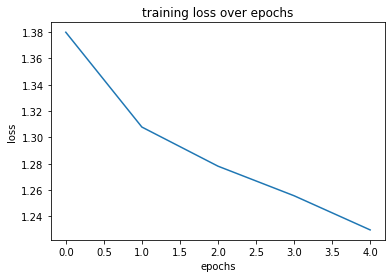

In [ ]:
plt.plot([float(l.split(':')[-1]) for l in lstur_model.history_loss['train']], label='logloss')
plt.title('training loss over epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

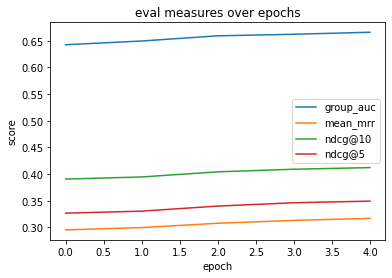

In [ ]:
plt.plot([float(l.split(',')[0].split(':')[-1]) for l in lstur_model.history_loss['eval']], label='group_auc')
plt.plot([float(l.split(',')[1].split(':')[-1]) for l in lstur_model.history_loss['eval']], label='mean_mrr')
plt.plot([float(l.split(',')[2].split(':')[-1]) for l in lstur_model.history_loss['eval']], label='ndcg@10')
plt.plot([float(l.split(',')[3].split(':')[-1]) for l in lstur_model.history_loss['eval']], label='ndcg@5')
plt.title('eval measures over epochs')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend()
plt.show()

### Overfitting measures

This plot will show the amount of overfitting in the model, the gap between the train loss and the evaluation measures

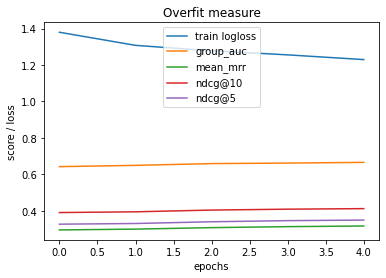

In [ ]:
plt.plot([float(l.split(':')[-1]) for l in lstur_model.history_loss['train']], label='train logloss')
plt.plot([float(l.split(',')[0].split(':')[-1]) for l in lstur_model.history_loss['eval']], label='group_auc')
plt.plot([float(l.split(',')[1].split(':')[-1]) for l in lstur_model.history_loss['eval']], label='mean_mrr')
plt.plot([float(l.split(',')[2].split(':')[-1]) for l in lstur_model.history_loss['eval']], label='ndcg@10')
plt.plot([float(l.split(',')[3].split(':')[-1]) for l in lstur_model.history_loss['eval']], label='ndcg@5')
plt.title("Overfit measure")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('score / loss')
plt.show()

# LSTUR - The Enhanced News Encoder 

In [ ]:
__all__ = ["MINDAllIterator"]


class MINDAllIterator(BaseIterator):
    """Train data loader for NAML model.
    The model require a special type of data format, where each instance contains a label, impresion id, user id,
    the candidate news articles and user's clicked news article. Articles are represented by title words,
    body words, verts and subverts.
    Iterator will not load the whole data into memory. Instead, it loads data into memory
    per mini-batch, so that large files can be used as input data.
    Attributes:
        col_spliter (str): column spliter in one line.
        ID_spliter (str): ID spliter in one line.
        batch_size (int): the samples num in one batch.
        title_size (int): max word num in news title.
        body_size (int): max word num in news body (abstract used in MIND).
        his_size (int): max clicked news num in user click history.
        npratio (int): negaive and positive ratio used in negative sampling. -1 means no need of negtive sampling.
    """

    def __init__(
        self,
        hparams,
        npratio=-1,
        col_spliter="\t",
        ID_spliter="%",
    ):
        """Initialize an iterator. Create necessary placeholders for the model.
        Args:
            hparams (object): Global hyper-parameters. Some key setttings such as head_num and head_dim are there.
            graph (object): the running graph. All created placeholder will be added to this graph.
            col_spliter (str): column spliter in one line.
            ID_spliter (str): ID spliter in one line.
        """
        self.col_spliter = col_spliter
        self.ID_spliter = ID_spliter
        self.batch_size = hparams.batch_size
        self.title_size = hparams.title_size
        self.body_size = hparams.body_size
        self.his_size = hparams.his_size
        self.npratio = npratio

        self.word_dict = self.load_dict(hparams.wordDict_file)
        self.vert_dict = self.load_dict(hparams.vertDict_file)
        self.subvert_dict = self.load_dict(hparams.subvertDict_file)
        self.uid2index = self.load_dict(hparams.userDict_file)

    def load_dict(self, file_path):
        """Load pickled file
        Args:
            file path (str): File path
        Returns:
            object: pickle load obj
        """
        with open(file_path, "rb") as f:
            return pickle.load(f)

    def init_news(self, news_file):
        """Init news information given news file, such as `news_title_index`, `news_abstract_index`.
        Args:
            news_file: path of news file
        """
        self.nid2index = {}
        news_title = [""]
        news_ab = [""]
        news_vert = [""]
        news_subvert = [""]

        with tf.io.gfile.GFile(news_file, "r") as rd:
            for line in rd:
                nid, vert, subvert, title, ab, url, _, _ = line.strip("\n").split(
                    self.col_spliter
                )

                if nid in self.nid2index:
                    continue

                self.nid2index[nid] = len(self.nid2index) + 1
                title = word_tokenize(title)
                ab = word_tokenize(ab)
                news_title.append(title)
                news_ab.append(ab)
                news_vert.append(vert)
                news_subvert.append(subvert)

        self.news_title_index = np.zeros(
            (len(news_title), self.title_size), dtype="int32"
        )

        self.news_ab_index = np.zeros((len(news_ab), self.body_size), dtype="int32")
        self.news_vert_index = np.zeros((len(news_vert), 1), dtype="int32")
        self.news_subvert_index = np.zeros((len(news_subvert), 1), dtype="int32")

        for news_index in range(len(news_title)):
            title = news_title[news_index]
            ab = news_ab[news_index]
            vert = news_vert[news_index]
            subvert = news_subvert[news_index]
            for word_index in range(min(self.title_size, len(title))):
                if title[word_index] in self.word_dict:
                    self.news_title_index[news_index, word_index] = self.word_dict[
                        title[word_index].lower()
                    ]
            for word_index_ab in range(min(self.body_size, len(ab))):
                if ab[word_index_ab] in self.word_dict:
                    self.news_ab_index[news_index, word_index_ab] = self.word_dict[
                        ab[word_index_ab].lower()
                    ]
            if vert in self.vert_dict:
                self.news_vert_index[news_index, 0] = self.vert_dict[vert]
            if subvert in self.subvert_dict:
                self.news_subvert_index[news_index, 0] = self.subvert_dict[subvert]

    def init_behaviors(self, behaviors_file):
        """Init behavior logs given behaviors file.
        Args:
            behaviors_file (str): path of behaviors file
        """
        self.histories = []
        self.imprs = []
        self.labels = []
        self.impr_indexes = []
        self.uindexes = []

        with tf.io.gfile.GFile(behaviors_file, "r") as rd:
            impr_index = 0
            for line in rd:
                uid, time, history, impr = line.strip("\n").split(self.col_spliter)[-4:]

                history = [self.nid2index[i] for i in history.split()]
                history = [0] * (self.his_size - len(history)) + history[
                    : self.his_size
                ]

                impr_news = [self.nid2index[i.split("-")[0]] for i in impr.split()]
                label = [int(i.split("-")[1]) for i in impr.split()]
                uindex = self.uid2index[uid] if uid in self.uid2index else 0

                self.histories.append(history)
                self.imprs.append(impr_news)
                self.labels.append(label)
                self.impr_indexes.append(impr_index)
                self.uindexes.append(uindex)
                impr_index += 1

    def parser_one_line(self, line):
        """Parse one string line into feature values.
        Args:
            line (str): a string indicating one instance.
        Yields:
            list: Parsed results including label, impression id , user id,
            candidate_title_index, clicked_title_index,
            candidate_ab_index, clicked_ab_index,
            candidate_vert_index, clicked_vert_index,
            candidate_subvert_index, clicked_subvert_index,
        """
        if self.npratio > 0:
            impr_label = self.labels[line]
            impr = self.imprs[line]

            poss = []
            negs = []

            for news, click in zip(impr, impr_label):
                if click == 1:
                    poss.append(news)
                else:
                    negs.append(news)

            for p in poss:
                candidate_title_index = []
                impr_index = []
                user_index = []
                label = [1] + [0] * self.npratio

                n = newsample(negs, self.npratio)
                candidate_title_index = self.news_title_index[[p] + n]
                candidate_ab_index = self.news_ab_index[[p] + n]
                candidate_vert_index = self.news_vert_index[[p] + n]
                candidate_subvert_index = self.news_subvert_index[[p] + n]
                click_title_index = self.news_title_index[self.histories[line]]
                click_ab_index = self.news_ab_index[self.histories[line]]
                click_vert_index = self.news_vert_index[self.histories[line]]
                click_subvert_index = self.news_subvert_index[self.histories[line]]
                impr_index.append(self.impr_indexes[line])
                user_index.append(self.uindexes[line])

                yield (
                    label,
                    impr_index,
                    user_index,
                    candidate_title_index,
                    candidate_ab_index,
                    candidate_vert_index,
                    candidate_subvert_index,
                    click_title_index,
                    click_ab_index,
                    click_vert_index,
                    click_subvert_index,
                )

        else:
            impr_label = self.labels[line]
            impr = self.imprs[line]

            for news, label in zip(impr, impr_label):
                candidate_title_index = []
                impr_index = []
                user_index = []
                label = [label]

                candidate_title_index.append(self.news_title_index[news])
                click_title_index = self.news_title_index[self.histories[line]]

                candidate_title_index = self.news_title_index[news]
                candidate_ab_index = self.news_ab_index[news]
                candidate_vert_index = self.news_vert_index[news]
                candidate_subvert_index = self.news_subvert_index[news]
                click_title_index = self.news_title_index[self.histories[line]]
                click_ab_index = self.news_ab_index[self.histories[line]]
                click_vert_index = self.news_vert_index[self.histories[line]]
                click_subvert_index = self.news_subvert_index[self.histories[line]]
                impr_index.append(self.impr_indexes[line])
                user_index.append(self.uindexes[line])

                yield (
                    label,
                    impr_index,
                    user_index,
                    candidate_title_index,
                    candidate_ab_index,
                    candidate_vert_index,
                    candidate_subvert_index,
                    click_title_index,
                    click_ab_index,
                    click_vert_index,
                    click_subvert_index,
                )

    def load_data_from_file(self, news_file, behavior_file):
        """Read and parse data from a file.
        Args:
            news_file (str): A file contains several informations of news.
            beahaviros_file (str): A file contains information of user impressions.
        Yields:
            object: An iterator that yields parsed results, in the format of graph feed_dict.
        """

        if not hasattr(self, "news_title_index"):
            self.init_news(news_file)

        if not hasattr(self, "impr_indexes"):
            self.init_behaviors(behavior_file)

        label_list = []
        imp_indexes = []
        user_indexes = []
        candidate_title_indexes = []
        candidate_ab_indexes = []
        candidate_vert_indexes = []
        candidate_subvert_indexes = []
        click_title_indexes = []
        click_ab_indexes = []
        click_vert_indexes = []
        click_subvert_indexes = []
        cnt = 0

        indexes = np.arange(len(self.labels))

        if self.npratio > 0:
            np.random.shuffle(indexes)

        for index in indexes:
            for (
                label,
                impr_index,
                user_index,
                candidate_title_index,
                candidate_ab_index,
                candidate_vert_index,
                candidate_subvert_index,
                click_title_index,
                click_ab_index,
                click_vert_index,
                click_subvert_index,
            ) in self.parser_one_line(index):
                candidate_title_indexes.append(candidate_title_index)
                candidate_ab_indexes.append(candidate_ab_index)
                candidate_vert_indexes.append(candidate_vert_index)
                candidate_subvert_indexes.append(candidate_subvert_index)
                click_title_indexes.append(click_title_index)
                click_ab_indexes.append(click_ab_index)
                click_vert_indexes.append(click_vert_index)
                click_subvert_indexes.append(click_subvert_index)
                imp_indexes.append(impr_index)
                user_indexes.append(user_index)
                label_list.append(label)

                cnt += 1
                if cnt >= self.batch_size:
                    yield self._convert_data(
                        label_list,
                        imp_indexes,
                        user_indexes,
                        candidate_title_indexes,
                        candidate_ab_indexes,
                        candidate_vert_indexes,
                        candidate_subvert_indexes,
                        click_title_indexes,
                        click_ab_indexes,
                        click_vert_indexes,
                        click_subvert_indexes,
                    )
                    label_list = []
                    imp_indexes = []
                    user_indexes = []
                    candidate_title_indexes = []
                    candidate_ab_indexes = []
                    candidate_vert_indexes = []
                    candidate_subvert_indexes = []
                    click_title_indexes = []
                    click_ab_indexes = []
                    click_vert_indexes = []
                    click_subvert_indexes = []
                    cnt = 0

    def _convert_data(
        self,
        label_list,
        imp_indexes,
        user_indexes,
        candidate_title_indexes,
        candidate_ab_indexes,
        candidate_vert_indexes,
        candidate_subvert_indexes,
        click_title_indexes,
        click_ab_indexes,
        click_vert_indexes,
        click_subvert_indexes,
    ):
        """Convert data into numpy arrays that are good for further model operation.
        Args:
            label_list (list): a list of ground-truth labels.
            imp_indexes (list): a list of impression indexes.
            user_indexes (list): a list of user indexes.
            candidate_title_indexes (list): the candidate news titles' words indices.
            candidate_ab_indexes (list): the candidate news abstarcts' words indices.
            candidate_vert_indexes (list): the candidate news verts' words indices.
            candidate_subvert_indexes (list): the candidate news subverts' indices.
            click_title_indexes (list): words indices for user's clicked news titles.
            click_ab_indexes (list): words indices for user's clicked news abstarcts.
            click_vert_indexes (list): indices for user's clicked news verts.
            click_subvert_indexes (list):indices for user's clicked news subverts.
        Returns:
            dict: A dictionary, containing multiple numpy arrays that are convenient for further operation.
        """

        labels = np.asarray(label_list, dtype=np.float32)
        imp_indexes = np.asarray(imp_indexes, dtype=np.int32)
        user_indexes = np.asarray(user_indexes, dtype=np.int32)
        candidate_title_index_batch = np.asarray(
            candidate_title_indexes, dtype=np.int64
        )
        candidate_ab_index_batch = np.asarray(candidate_ab_indexes, dtype=np.int64)
        candidate_vert_index_batch = np.asarray(candidate_vert_indexes, dtype=np.int64)
        candidate_subvert_index_batch = np.asarray(
            candidate_subvert_indexes, dtype=np.int64
        )
        click_title_index_batch = np.asarray(click_title_indexes, dtype=np.int64)
        click_ab_index_batch = np.asarray(click_ab_indexes, dtype=np.int64)
        click_vert_index_batch = np.asarray(click_vert_indexes, dtype=np.int64)
        click_subvert_index_batch = np.asarray(click_subvert_indexes, dtype=np.int64)
        return {
            "impression_index_batch": imp_indexes,
            "user_index_batch": user_indexes,
            "clicked_title_batch": click_title_index_batch,
            "clicked_ab_batch": click_ab_index_batch,
            "clicked_vert_batch": click_vert_index_batch,
            "clicked_subvert_batch": click_subvert_index_batch,
            "candidate_title_batch": candidate_title_index_batch,
            "candidate_ab_batch": candidate_ab_index_batch,
            "candidate_vert_batch": candidate_vert_index_batch,
            "candidate_subvert_batch": candidate_subvert_index_batch,
            "labels": labels,
        }

    def load_user_from_file(self, news_file, behavior_file):
        """Read and parse user data from news file and behavior file.
        Args:
            news_file (str): A file contains several informations of news.
            beahaviros_file (str): A file contains information of user impressions.
        Yields:
            object: An iterator that yields parsed user feature, in the format of dict.
        """

        if not hasattr(self, "news_title_index"):
            self.init_news(news_file)

        if not hasattr(self, "impr_indexes"):
            self.init_behaviors(behavior_file)

        user_indexes = []
        impr_indexes = []
        click_title_indexes = []
        click_ab_indexes = []
        click_vert_indexes = []
        click_subvert_indexes = []
        cnt = 0

        for index in range(len(self.impr_indexes)):
            click_title_indexes.append(self.news_title_index[self.histories[index]])
            click_ab_indexes.append(self.news_ab_index[self.histories[index]])
            click_vert_indexes.append(self.news_vert_index[self.histories[index]])
            click_subvert_indexes.append(self.news_subvert_index[self.histories[index]])
            user_indexes.append(self.uindexes[index])
            impr_indexes.append(self.impr_indexes[index])

            cnt += 1
            if cnt >= self.batch_size:
                yield self._convert_user_data(
                    user_indexes,
                    impr_indexes,
                    click_title_indexes,
                    click_ab_indexes,
                    click_vert_indexes,
                    click_subvert_indexes,
                )
                user_indexes = []
                impr_indexes = []
                click_title_indexes = []
                click_ab_indexes = []
                click_vert_indexes = []
                click_subvert_indexes = []

    def _convert_user_data(
        self,
        user_indexes,
        impr_indexes,
        click_title_indexes,
        click_ab_indexes,
        click_vert_indexes,
        click_subvert_indexes,
    ):
        """Convert data into numpy arrays that are good for further model operation.
        Args:
            user_indexes (list): a list of user indexes.
            click_title_indexes (list): words indices for user's clicked news titles.
            click_ab_indexes (list): words indices for user's clicked news abs.
            click_vert_indexes (list): words indices for user's clicked news verts.
            click_subvert_indexes (list): words indices for user's clicked news subverts.
        Returns:
            dict: A dictionary, containing multiple numpy arrays that are convenient for further operation.
        """

        user_indexes = np.asarray(user_indexes, dtype=np.int32)
        impr_indexes = np.asarray(impr_indexes, dtype=np.int32)
        click_title_index_batch = np.asarray(click_title_indexes, dtype=np.int64)
        click_ab_index_batch = np.asarray(click_ab_indexes, dtype=np.int64)
        click_vert_index_batch = np.asarray(click_vert_indexes, dtype=np.int64)
        click_subvert_index_batch = np.asarray(click_subvert_indexes, dtype=np.int64)

        return {
            "user_index_batch": user_indexes,
            "impr_index_batch": impr_indexes,
            "clicked_title_batch": click_title_index_batch,
            "clicked_ab_batch": click_ab_index_batch,
            "clicked_vert_batch": click_vert_index_batch,
            "clicked_subvert_batch": click_subvert_index_batch,
        }

    def load_news_from_file(self, news_file):
        """Read and parse user data from news file.
        Args:
            news_file (str): A file contains several informations of news.
        Yields:
            object: An iterator that yields parsed news feature, in the format of dict.
        """
        if not hasattr(self, "news_title_index"):
            self.init_news(news_file)

        news_indexes = []
        candidate_title_indexes = []
        candidate_ab_indexes = []
        candidate_vert_indexes = []
        candidate_subvert_indexes = []
        cnt = 0

        for index in range(len(self.news_title_index)):
            news_indexes.append(index)
            candidate_title_indexes.append(self.news_title_index[index])
            candidate_ab_indexes.append(self.news_ab_index[index])
            candidate_vert_indexes.append(self.news_vert_index[index])
            candidate_subvert_indexes.append(self.news_subvert_index[index])

            cnt += 1
            if cnt >= self.batch_size:
                yield self._convert_news_data(
                    news_indexes,
                    candidate_title_indexes,
                    candidate_ab_indexes,
                    candidate_vert_indexes,
                    candidate_subvert_indexes,
                )
                news_indexes = []
                candidate_title_indexes = []
                candidate_ab_indexes = []
                candidate_vert_indexes = []
                candidate_subvert_indexes = []

    def _convert_news_data(
        self,
        news_indexes,
        candidate_title_indexes,
        candidate_ab_indexes,
        candidate_vert_indexes,
        candidate_subvert_indexes,
    ):
        """Convert data into numpy arrays that are good for further model operation.
        Args:
            news_indexes (list): a list of news indexes.
            candidate_title_indexes (list): the candidate news titles' words indices.
            candidate_ab_indexes (list): the candidate news abstarcts' words indices.
            candidate_vert_indexes (list): the candidate news verts' words indices.
            candidate_subvert_indexes (list): the candidate news subverts' words indices.
        Returns:
            dict: A dictionary, containing multiple numpy arrays that are convenient for further operation.
        """

        news_indexes_batch = np.asarray(news_indexes, dtype=np.int32)
        candidate_title_index_batch = np.asarray(
            candidate_title_indexes, dtype=np.int32
        )
        candidate_ab_index_batch = np.asarray(candidate_ab_indexes, dtype=np.int32)
        candidate_vert_index_batch = np.asarray(candidate_vert_indexes, dtype=np.int32)
        candidate_subvert_index_batch = np.asarray(
            candidate_subvert_indexes, dtype=np.int32
        )

        return {
            "news_index_batch": news_indexes_batch,
            "candidate_title_batch": candidate_title_index_batch,
            "candidate_ab_batch": candidate_ab_index_batch,
            "candidate_vert_batch": candidate_vert_index_batch,
            "candidate_subvert_batch": candidate_subvert_index_batch,
        }

    def load_impression_from_file(self, behaivors_file):
        """Read and parse impression data from behaivors file.
        Args:
            behaivors_file (str): A file contains several informations of behaviros.
        Yields:
            object: An iterator that yields parsed impression data, in the format of dict.
        """

        if not hasattr(self, "histories"):
            self.init_behaviors(behaivors_file)

        indexes = np.arange(len(self.labels))

        for index in indexes:
            impr_label = np.array(self.labels[index], dtype="int32")
            impr_news = np.array(self.imprs[index], dtype="int32")

            yield (
                self.impr_indexes[index],
                impr_news,
                self.uindexes[index],
                impr_label,
            )

## LSTUR - the enhanced model

In [ ]:
__all__ = ["LSTUR_enhanced"]


class LSTUR_enhanced(BaseModel):
    """
    Attributes:
        word2vec_embedding (numpy.ndarray): Pretrained word embedding matrix.
        hparam (object): Global hyper-parameters.
    """

    def __init__(self, hparams, iterator_creator, seed=None):

        self.word2vec_embedding = self._init_embedding(hparams.wordEmb_file)
        self.hparam = hparams

        super().__init__(hparams, iterator_creator, seed=seed)

    def _get_input_label_from_iter(self, batch_data):
        input_feat = [
            batch_data["user_index_batch"],
            batch_data["clicked_title_batch"],
            batch_data["clicked_ab_batch"],
            batch_data["clicked_vert_batch"],
            batch_data["clicked_subvert_batch"],
            batch_data["candidate_title_batch"],
            batch_data["candidate_ab_batch"],
            batch_data["candidate_vert_batch"],
            batch_data["candidate_subvert_batch"],
        ]
        input_label = batch_data["labels"]
        return input_feat, input_label

    def _get_user_feature_from_iter(self, batch_data):
        """ get input of user encoder 
        Args:
            batch_data: input batch data from user iterator
        
        Returns:
            numpy.ndarray: input user feature (clicked title batch)
        """

        input_feature = [
            batch_data["clicked_title_batch"],
            batch_data["clicked_ab_batch"],
            batch_data["clicked_vert_batch"],
            batch_data["clicked_subvert_batch"],
        ]
        input_feature = np.concatenate(input_feature, axis=-1)
        return [input_feature, batch_data["user_index_batch"]]

    def _get_news_feature_from_iter(self, batch_data):
        """ get input of news encoder
        Args:
            batch_data: input batch data from news iterator
        
        Returns:
            numpy.ndarray: input news feature (candidate title batch)
        """
        input_feature = [
            batch_data["candidate_title_batch"],
            batch_data["candidate_ab_batch"],
            batch_data["candidate_vert_batch"],
            batch_data["candidate_subvert_batch"],
        ]
        input_feature = np.concatenate(input_feature, axis=-1)
        return input_feature

    def _build_graph(self):
        """Build NAML model and scorer.
        Returns:
            object: a model used to train.
            object: a model used to evaluate and inference.
        """

        model, scorer = self._build_naml()
        return model, scorer

    def _build_userencoder(self, titleencoder, type="ini"):
        """The main function to create user encoder of LSTUR.
        Args:
            titleencoder(obj): the news encoder of LSTUR. 
        Return:
            obj: the user encoder of LSTUR.
        """
        hparams = self.hparams
        his_input_title = keras.Input(
            shape=(hparams.his_size, hparams.title_size + hparams.body_size + 2), dtype="int32"
        )
        user_indexes = keras.Input(shape=(1,), dtype="int32")

        user_embedding_layer = layers.Embedding(
            len(self.train_iterator.uid2index),
            hparams.gru_unit,
            trainable=True,
            embeddings_initializer="zeros",
        )

        long_u_emb = layers.Reshape((hparams.gru_unit,))(
            user_embedding_layer(user_indexes)
        )
        click_title_presents = layers.TimeDistributed(titleencoder)(his_input_title)

        if type == "ini":
            user_present = layers.GRU(
                hparams.gru_unit,
                kernel_initializer=keras.initializers.glorot_uniform(seed=self.seed),
                recurrent_initializer=keras.initializers.glorot_uniform(seed=self.seed),
                bias_initializer=keras.initializers.Zeros(),
            )(
                layers.Masking(mask_value=0.0)(click_title_presents),
                initial_state=[long_u_emb],
            )
        elif type == "con":
            short_uemb = layers.GRU(
                hparams.gru_unit,
                kernel_initializer=keras.initializers.glorot_uniform(seed=self.seed),
                recurrent_initializer=keras.initializers.glorot_uniform(seed=self.seed),
                bias_initializer=keras.initializers.Zeros(),
            )(layers.Masking(mask_value=0.0)(click_title_presents))

            user_present = layers.Concatenate()([short_uemb, long_u_emb])
            user_present = layers.Dense(
                hparams.gru_unit,
                bias_initializer=keras.initializers.Zeros(),
                kernel_initializer=keras.initializers.glorot_uniform(seed=self.seed),
            )(user_present)

        model = keras.Model(
            [his_input_title, user_indexes], user_present, name="user_encoder"
        )
        return model

    def _build_newsencoder(self, embedding_layer):
        """The main function to create news encoder of NAML.
        news encoder in composed of title encoder, body encoder, vert encoder and subvert encoder
        Args:
            embedding_layer (object): a word embedding layer.
        
        Return:
            object: the news encoder of NAML.
        """
        hparams = self.hparams
        input_title_body_verts = keras.Input(
            shape=(hparams.title_size + hparams.body_size + 2,), dtype="int32"
        )

        sequences_input_title = layers.Lambda(lambda x: x[:, : hparams.title_size])(
            input_title_body_verts
        )
        sequences_input_body = layers.Lambda(
            lambda x: x[:, hparams.title_size : hparams.title_size + hparams.body_size]
        )(input_title_body_verts)
        input_vert = layers.Lambda(
            lambda x: x[
                :,
                hparams.title_size
                + hparams.body_size : hparams.title_size
                + hparams.body_size
                + 1,
            ]
        )(input_title_body_verts)
        input_subvert = layers.Lambda(
            lambda x: x[:, hparams.title_size + hparams.body_size + 1 :]
        )(input_title_body_verts)

        title_repr = self._build_titleencoder(embedding_layer)(sequences_input_title)
        body_repr = self._build_bodyencoder(embedding_layer)(sequences_input_body)
        vert_repr = self._build_vertencoder()(input_vert)
        subvert_repr = self._build_subvertencoder()(input_subvert)

        concate_repr = layers.Concatenate(axis=-2)(
            [title_repr, body_repr, vert_repr, subvert_repr]
        )
        news_repr = AttLayer2(hparams.attention_hidden_dim, seed=self.seed)(
            concate_repr
        )

        model = keras.Model(input_title_body_verts, news_repr, name="news_encoder")
        return model

    def _build_titleencoder(self, embedding_layer):
        """build title encoder of NAML news encoder.
        Args:
            embedding_layer (object): a word embedding layer.
        
        Return:
            object: the title encoder of NAML.
        """
        hparams = self.hparams
        sequences_input_title = keras.Input(shape=(hparams.title_size,), dtype="int32")
        embedded_sequences_title = embedding_layer(sequences_input_title)
        
        y = layers.Dropout(hparams.dropout)(embedded_sequences_title)
        y = layers.Conv1D(
            hparams.filter_num,
            hparams.window_size,
            activation=hparams.cnn_activation,
            padding="same",
            bias_initializer=keras.initializers.Zeros(),
            kernel_initializer=keras.initializers.glorot_uniform(seed=self.seed),
        )(y)
        y = layers.Dropout(hparams.dropout)(y)
        pred_title = AttLayer2(hparams.attention_hidden_dim, seed=self.seed)(y)
        pred_title = layers.Reshape((1, hparams.filter_num))(pred_title)

        model = keras.Model(sequences_input_title, pred_title, name="title_encoder")
        return model

    def _build_bodyencoder(self, embedding_layer):
        """build body encoder of NAML news encoder.
        Args:
            embedding_layer (object): a word embedding layer.
        
        Return:
            object: the body encoder of NAML.
        """
        hparams = self.hparams
        sequences_input_body = keras.Input(shape=(hparams.body_size,), dtype="int32")
        embedded_sequences_body = embedding_layer(sequences_input_body)

        y = layers.Dropout(hparams.dropout)(embedded_sequences_body)
        y = layers.Conv1D(
            hparams.filter_num,
            hparams.window_size,
            activation=hparams.cnn_activation,
            padding="same",
            bias_initializer=keras.initializers.Zeros(),
            kernel_initializer=keras.initializers.glorot_uniform(seed=self.seed),
        )(y)
        y = layers.Dropout(hparams.dropout)(y)
        pred_body = AttLayer2(hparams.attention_hidden_dim, seed=self.seed)(y)
        pred_body = layers.Reshape((1, hparams.filter_num))(pred_body)

        model = keras.Model(sequences_input_body, pred_body, name="body_encoder")
        return model

    def _build_vertencoder(self):
        """build vert encoder of NAML news encoder.
        Return:
            object: the vert encoder of NAML.
        """
        hparams = self.hparams
        input_vert = keras.Input(shape=(1,), dtype="int32")

        vert_embedding = layers.Embedding(
            hparams.vert_num, hparams.vert_emb_dim, trainable=True
        )

        vert_emb = vert_embedding(input_vert)
        pred_vert = layers.Dense(
            hparams.filter_num,
            activation=hparams.dense_activation,
            bias_initializer=keras.initializers.Zeros(),
            kernel_initializer=keras.initializers.glorot_uniform(seed=self.seed),
        )(vert_emb)
        pred_vert = layers.Reshape((1, hparams.filter_num))(pred_vert)

        model = keras.Model(input_vert, pred_vert, name="vert_encoder")
        return model

    def _build_subvertencoder(self):
        """build subvert encoder of NAML news encoder.
        Return:
            object: the subvert encoder of NAML.
        """
        hparams = self.hparams
        input_subvert = keras.Input(shape=(1,), dtype="int32")

        subvert_embedding = layers.Embedding(
            hparams.subvert_num, hparams.subvert_emb_dim, trainable=True
        )

        subvert_emb = subvert_embedding(input_subvert)
        pred_subvert = layers.Dense(
            hparams.filter_num,
            activation=hparams.dense_activation,
            bias_initializer=keras.initializers.Zeros(),
            kernel_initializer=keras.initializers.glorot_uniform(seed=self.seed),
        )(subvert_emb)
        pred_subvert = layers.Reshape((1, hparams.filter_num))(pred_subvert)

        model = keras.Model(input_subvert, pred_subvert, name="subvert_encoder")
        return model

    def _build_naml(self):
        """The main function to create NAML's logic. The core of NAML
        is a user encoder and a news encoder.
        
        Returns:
            object: a model used to train.
            object: a model used to evaluate and predict.
        """
        hparams = self.hparams

        his_input_title = keras.Input(
            shape=(hparams.his_size, hparams.title_size), dtype="int32",
            name="his_input_title"
        )
        his_input_body = keras.Input(
            shape=(hparams.his_size, hparams.body_size), dtype="int32",
            name="his_input_body"
        )
        his_input_vert = keras.Input(shape=(hparams.his_size, 1), dtype="int32", name="his_input_vert")
        his_input_subvert = keras.Input(shape=(hparams.his_size, 1), dtype="int32", name="his_input_subvert")

        pred_input_title = keras.Input(
            shape=(hparams.npratio + 1, hparams.title_size), dtype="int32",
            name="pred_input_title"
        )
        pred_input_body = keras.Input(
            shape=(hparams.npratio + 1, hparams.body_size), dtype="int32",
            name="pred_input_body"
        )
        pred_input_vert = keras.Input(shape=(hparams.npratio + 1, 1), dtype="int32", name="pred_input_vert")
        pred_input_subvert = keras.Input(shape=(hparams.npratio + 1, 1), dtype="int32", name="pred_input_subvert")

        pred_input_title_one = keras.Input(
            shape=(1, hparams.title_size,), dtype="int32", name="pred_input_title_one"
        )
        pred_input_body_one = keras.Input(shape=(1, hparams.body_size,), dtype="int32", name="pred_input_body_one")
        pred_input_vert_one = keras.Input(shape=(1, 1), dtype="int32", name="pred_input_vert_one")
        pred_input_subvert_one = keras.Input(shape=(1, 1), dtype="int32", name="pred_input_subvert_one")
        user_indexes = keras.Input(shape=(1,), dtype="int32", name="user_indexes")

        his_title_body_verts = layers.Concatenate(axis=-1)(
            [his_input_title, his_input_body, his_input_vert, his_input_subvert]
        )

        pred_title_body_verts = layers.Concatenate(axis=-1)(
            [pred_input_title, pred_input_body, pred_input_vert, pred_input_subvert]
        )

        pred_title_body_verts_one = layers.Concatenate(axis=-1)(
            [
                pred_input_title_one,
                pred_input_body_one,
                pred_input_vert_one,
                pred_input_subvert_one,
            ]
        )
        pred_title_body_verts_one = layers.Reshape((-1,))(pred_title_body_verts_one)

        embedding_layer = layers.Embedding(
            self.word2vec_embedding.shape[0],
            hparams.word_emb_dim,
            weights=[self.word2vec_embedding],
            trainable=True,
        )

        self.newsencoder = self._build_newsencoder(embedding_layer)
        self.userencoder = self._build_userencoder(self.newsencoder)

        user_present = self.userencoder([his_title_body_verts, user_indexes])
        news_present = layers.TimeDistributed(self.newsencoder)(pred_title_body_verts)
        news_present_one = self.newsencoder(pred_title_body_verts_one)

        preds = layers.Dot(axes=-1)([news_present, user_present])
        preds = layers.Activation(activation="softmax")(preds)

        pred_one = layers.Dot(axes=-1)([news_present_one, user_present])
        pred_one = layers.Activation(activation="sigmoid")(pred_one)

        model = keras.Model(
            [
                user_indexes,
                his_input_title,
                his_input_body,
                his_input_vert,
                his_input_subvert,
                pred_input_title,
                pred_input_body,
                pred_input_vert,
                pred_input_subvert,
            ],
            preds,
        )

        scorer = keras.Model(
            [
                user_indexes,
                his_input_title,
                his_input_body,
                his_input_vert,
                his_input_subvert,
                pred_input_title_one,
                pred_input_body_one,
                pred_input_vert_one,
                pred_input_subvert_one,
            ],
            pred_one,
        )

        return model, scorer

## Train the enahnced model

In [ ]:
epochs = 5
seed = 40
batch_size = 32

# Options: demo, small, large
# MIND_type = 'demo'

In [ ]:
tmpdir = TemporaryDirectory()
data_path = tmpdir.name

train_news_file = os.path.join(data_path, 'train', r'news.tsv')
train_behaviors_file = os.path.join(data_path, 'train', r'behaviors.tsv')
valid_news_file = os.path.join(data_path, 'valid', r'news.tsv')
valid_behaviors_file = os.path.join(data_path, 'valid', r'behaviors.tsv')
wordEmb_file = os.path.join(data_path, "utils", "embedding_all.npy")
userDict_file = os.path.join(data_path, "utils", "uid2index.pkl")
wordDict_file = os.path.join(data_path, "utils", "word_dict_all.pkl")
vertDict_file = os.path.join(data_path, "utils", "vert_dict.pkl")
subvertDict_file = os.path.join(data_path, "utils", "subvert_dict.pkl")
yaml_file = os.path.join(data_path, "utils", r'naml.yaml')

mind_url, mind_train_dataset, mind_dev_dataset, mind_utils = get_mind_data_set(MIND_type)

if not os.path.exists(train_news_file):
    download_deeprec_resources(mind_url, os.path.join(data_path, 'train'), mind_train_dataset)
    
if not os.path.exists(valid_news_file):
    download_deeprec_resources(mind_url, \
                               os.path.join(data_path, 'valid'), mind_dev_dataset)
if not os.path.exists(yaml_file):
    download_deeprec_resources(r'https://recodatasets.z20.web.core.windows.net/newsrec/', \
                               os.path.join(data_path, 'utils'), mind_utils)

100%|██████████| 51.7k/51.7k [00:03<00:00, 13.7kKB/s]
100%|██████████| 30.2k/30.2k [00:02<00:00, 11.3kKB/s]
100%|██████████| 152k/152k [00:02<00:00, 61.9kKB/s] 


In [ ]:
hparams = prepare_hparams(yaml_file, 
                          wordEmb_file=wordEmb_file,
                          wordDict_file=wordDict_file, 
                          userDict_file=userDict_file,
                          vertDict_file=vertDict_file, 
                          subvertDict_file=subvertDict_file,
                          batch_size=batch_size,
                          epochs=epochs)
print(hparams)

data_format=naml,iterator_type=None,support_quick_scoring=True,wordEmb_file=/tmp/tmp1iw5v56c/utils/embedding_all.npy,wordDict_file=/tmp/tmp1iw5v56c/utils/word_dict_all.pkl,userDict_file=/tmp/tmp1iw5v56c/utils/uid2index.pkl,vertDict_file=/tmp/tmp1iw5v56c/utils/vert_dict.pkl,subvertDict_file=/tmp/tmp1iw5v56c/utils/subvert_dict.pkl,title_size=30,body_size=50,word_emb_dim=300,word_size=None,user_num=None,vert_num=17,subvert_num=249,his_size=50,npratio=4,dropout=0.2,attention_hidden_dim=200,head_num=4,head_dim=100,cnn_activation=relu,dense_activation=relu,filter_num=400,window_size=3,vert_emb_dim=100,subvert_emb_dim=100,gru_unit=400,type=ini,user_emb_dim=50,learning_rate=0.0001,loss=cross_entropy_loss,optimizer=adam,epochs=5,batch_size=32,show_step=100000,metrics=['group_auc', 'mean_mrr', 'ndcg@5;10']


In [ ]:
iterator = MINDAllIterator

In [ ]:
enhanced_model = LSTUR_enhanced(hparams, iterator, seed=seed)

In [ ]:
print(enhanced_model.run_eval(valid_news_file, valid_behaviors_file))

42386it [02:03, 344.54it/s]
73121it [29:47, 40.90it/s]
73152it [00:19, 3751.81it/s]


{'group_auc': 0.5351, 'mean_mrr': 0.2327, 'ndcg@5': 0.2377, 'ndcg@10': 0.3003}


In [ ]:
%%time
enhanced_model.fit(train_news_file, train_behaviors_file,valid_news_file, valid_behaviors_file)

7385it [20:46,  5.93it/s]
42386it [01:59, 354.10it/s]
73121it [29:20, 41.53it/s]
73152it [00:18, 3853.32it/s]


at epoch 1
train info: logloss loss:1.3695503628326575
eval info: group_auc:0.659, mean_mrr:0.3111, ndcg@10:0.4076, ndcg@5:0.345
at epoch 1 , train time: 1246.1 eval time: 1988.0


7385it [19:57,  6.17it/s]
42386it [01:58, 357.70it/s]
73121it [29:03, 41.94it/s]
73152it [00:19, 3742.36it/s]


at epoch 2
train info: logloss loss:1.2914329702820257
eval info: group_auc:0.6658, mean_mrr:0.3122, ndcg@10:0.4111, ndcg@5:0.3494
at epoch 2 , train time: 1197.1 eval time: 1969.4


7385it [20:10,  6.10it/s]
42386it [01:59, 356.05it/s]
73121it [28:43, 42.43it/s]
73152it [00:19, 3843.66it/s]


at epoch 3
train info: logloss loss:1.2649976140595645
eval info: group_auc:0.6685, mean_mrr:0.3176, ndcg@10:0.4146, ndcg@5:0.3524
at epoch 3 , train time: 1210.2 eval time: 1949.8


7385it [20:04,  6.13it/s]
42386it [01:58, 357.59it/s]
73121it [29:20, 41.53it/s]
73152it [00:19, 3715.94it/s]


at epoch 4
train info: logloss loss:1.2462980859087542
eval info: group_auc:0.6712, mean_mrr:0.3171, ndcg@10:0.4152, ndcg@5:0.3527
at epoch 4 , train time: 1204.8 eval time: 1986.1


7385it [20:07,  6.12it/s]
42386it [01:58, 357.00it/s]
73121it [29:19, 41.55it/s]
73152it [00:19, 3820.99it/s]


at epoch 5
train info: logloss loss:1.2310148035261224
eval info: group_auc:0.6753, mean_mrr:0.3211, ndcg@10:0.4198, ndcg@5:0.3577
at epoch 5 , train time: 1207.5 eval time: 1986.0
CPU times: user 8h 5min 35s, sys: 57min 19s, total: 9h 2min 55s
Wall time: 4h 25min 44s


## Evaluation

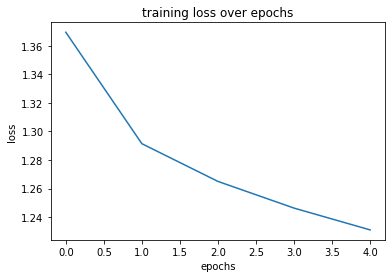

In [ ]:
plt.plot([float(l.split(':')[-1]) for l in enhanced_model.history_loss['train']], label='logloss')
plt.title('training loss over epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

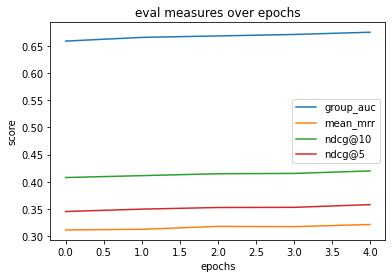

In [ ]:
plt.plot([float(l.split(',')[0].split(':')[-1]) for l in enhanced_model.history_loss['eval']], label='group_auc')
plt.plot([float(l.split(',')[1].split(':')[-1]) for l in enhanced_model.history_loss['eval']], label='mean_mrr')
plt.plot([float(l.split(',')[2].split(':')[-1]) for l in enhanced_model.history_loss['eval']], label='ndcg@10')
plt.plot([float(l.split(',')[3].split(':')[-1]) for l in enhanced_model.history_loss['eval']], label='ndcg@5')
plt.title('eval measures over epochs')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend()
plt.show()

### Overfitting measures

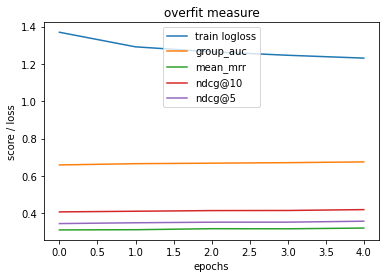

In [ ]:
plt.plot([float(l.split(':')[-1]) for l in enhanced_model.history_loss['train']], label='train logloss')
plt.plot([float(l.split(',')[0].split(':')[-1]) for l in enhanced_model.history_loss['eval']], label='group_auc')
plt.plot([float(l.split(',')[1].split(':')[-1]) for l in enhanced_model.history_loss['eval']], label='mean_mrr')
plt.plot([float(l.split(',')[2].split(':')[-1]) for l in enhanced_model.history_loss['eval']], label='ndcg@10')
plt.plot([float(l.split(',')[3].split(':')[-1]) for l in enhanced_model.history_loss['eval']], label='ndcg@5')
plt.title('overfit measure')
plt.xlabel('epochs')
plt.ylabel('score / loss')
plt.legend()
plt.show()

# Evaluation of LSTUR vs Enhanced LSTUR

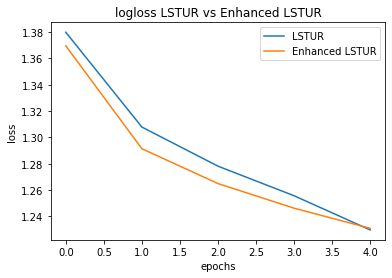

In [ ]:
plt.plot([float(l.split(':')[-1]) for l in lstur_model.history_loss['train']], label='LSTUR')
plt.plot([float(l.split(':')[-1]) for l in enhanced_model.history_loss['train']], label='Enhanced LSTUR')
plt.title('logloss LSTUR vs Enhanced LSTUR')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

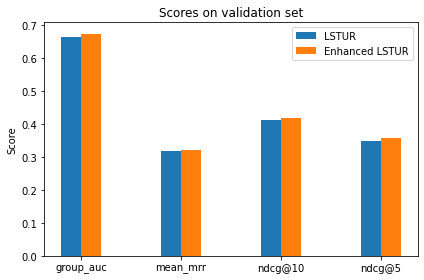

In [ ]:
labels = ['group_auc', 'mean_mrr', 'ndcg@10', 'ndcg@5']

lstur_measures = [float(lstur_model.history_loss['eval'][-1].split(',')[l].split(':')[-1]) for l in range(len(labels))]
enhanced_lstur_measures = [float(enhanced_model.history_loss['eval'][-1].split(',')[l].split(':')[-1]) for l in range(len(labels))]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, lstur_measures, width, label='LSTUR')
rects2 = ax.bar(x + width/2, enhanced_lstur_measures, width, label='Enhanced LSTUR')

ax.set_ylabel('Score')
ax.set_title('Scores on validation set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()

# Reference
\[1\] Mingxiao An, Fangzhao Wu, Chuhan Wu, Kun Zhang, Zheng Liu and Xing Xie: Neural News Recommendation with Long- and Short-term User Representations, ACL 2019<br>
\[2\] Wu, Fangzhao, et al. "MIND: A Large-scale Dataset for News Recommendation" Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics. https://msnews.github.io/competition.html <br>
\[3\] GloVe: Global Vectors for Word Representation. https://nlp.stanford.edu/projects/glove/